In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

import soundfile as sf
import librosa

from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import random

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
DEVICE


'cuda'

In [2]:
CWD = Path().resolve()
PROJECT_ROOT = CWD.parents[1]

OUT_ROOT = PROJECT_ROOT / "data" / "processed" / "ka"
CSV_PATH = OUT_ROOT / "ka_segments.csv"

OUT_DIR = OUT_ROOT / "baseline_runs_ka_all_labels"
OUT_DIR.mkdir(parents=True, exist_ok=True)

CACHE_DIR = PROJECT_ROOT / "data" / "processed" / "ka" / "feature_cache"
CACHE_DIR.mkdir(parents=True, exist_ok=True)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("CSV_PATH     :", CSV_PATH)
print("OUT_DIR      :", OUT_DIR)
print("CACHE_DIR    :", CACHE_DIR)


PROJECT_ROOT: C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds
CSV_PATH     : C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\ka\ka_segments.csv
OUT_DIR      : C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\ka\baseline_runs_ka_all_labels
CACHE_DIR    : C:\Users\MSI\Documents\Persoonlijke Projecten\AI-Onderzoeksvragen\research_questions\heart_and_lungsounds\data\processed\ka\feature_cache


In [3]:
df = pd.read_csv(CSV_PATH)

if "audio_path" not in df.columns:
    raise ValueError("Expected column 'audio_path' in ka_segments.csv")

def resolve_audio_path(p: str) -> Path:
    p = str(p).strip()
    return (PROJECT_ROOT / p).resolve()

df["audio_path_resolved"] = df["audio_path"].astype(str).map(resolve_audio_path)
df["audio_exists"] = df["audio_path_resolved"].map(lambda p: Path(p).exists())

missing = (~df["audio_exists"]).sum()
print("Rows:", len(df), "| Missing audio:", int(missing))

df = df[df["audio_exists"]].reset_index(drop=True)
assert len(df) > 0, "No audio found after resolving paths."


Rows: 5174 | Missing audio: 0


In [4]:
col = "diagnosis_norm"

# drop echte NaN / missing
df = df.dropna(subset=[col]).copy()

# drop string-varianten van "nan" en lege strings
s = df[col].astype(str).str.strip()
df = df[~s.str.lower().isin(["nan", "none", ""])]  # voeg evt. "unknown" toe als je die ook wilt droppen
df = df.reset_index(drop=True)

In [5]:
df['diagnosis_norm'].value_counts()

diagnosis_norm
Normal           1655
Asthma           1446
Heart Failure     942
COPD              420
Pneumonia         261
BRON              102
Name: count, dtype: int64

In [6]:
LABEL_COL = "diagnosis_norm"
GROUP_COL = "patient_id"

if LABEL_COL not in df.columns:
    raise ValueError(f"Expected column '{LABEL_COL}' in ka_segments.csv")
if GROUP_COL not in df.columns:
    raise ValueError(f"Expected column '{GROUP_COL}' in ka_segments.csv")

df[LABEL_COL] = df[LABEL_COL].astype(str).str.strip()

LABELS = sorted(df[LABEL_COL].unique().tolist())
label2id = {l:i for i,l in enumerate(LABELS)}
id2label = {i:l for l,i in label2id.items()}

df["y"] = df[LABEL_COL].map(label2id).astype(int)

print("Num classes:", len(LABELS))
df[LABEL_COL].value_counts()

Num classes: 6


diagnosis_norm
Normal           1655
Asthma           1446
Heart Failure     942
COPD              420
Pneumonia         261
BRON              102
Name: count, dtype: int64

In [7]:
from sklearn.model_selection import GroupShuffleSplit
import numpy as np

def _has_all_labels(df_split, label_col, labels):
    present = set(df_split[label_col].unique().tolist())
    return all(l in present for l in labels)

def split_by_group_with_label_coverage(
    df,
    group_col,
    label_col,
    labels,
    seed=42,
    test_size=0.15,
    val_size=0.15,
    max_tries=2000,
    min_per_split=1,   # zet bv 1 of 2
):
    rng = np.random.RandomState(seed)
    labels = list(labels)

    def meets_min(df_split):
        vc = df_split[label_col].value_counts()
        return all(vc.get(l, 0) >= min_per_split for l in labels)

    for _ in range(max_tries):
        s1 = int(rng.randint(0, 10_000_000))
        gss1 = GroupShuffleSplit(n_splits=1, test_size=test_size, random_state=s1)
        tr_idx, te_idx = next(gss1.split(df, groups=df[group_col]))
        df_tr = df.iloc[tr_idx].reset_index(drop=True)
        df_te = df.iloc[te_idx].reset_index(drop=True)

        if not _has_all_labels(df_te, label_col, labels):
            continue
        if min_per_split and not meets_min(df_te):
            continue

        # val uit train trekken
        s2 = int(rng.randint(0, 10_000_000))
        # val_size is fractie van totale df; binnen df_tr moet je hernormaliseren:
        val_frac_within_tr = val_size / (1.0 - test_size)

        gss2 = GroupShuffleSplit(n_splits=1, test_size=val_frac_within_tr, random_state=s2)
        tr2_idx, va_idx = next(gss2.split(df_tr, groups=df_tr[group_col]))
        df_train = df_tr.iloc[tr2_idx].reset_index(drop=True)
        df_val   = df_tr.iloc[va_idx].reset_index(drop=True)

        ok = (
            _has_all_labels(df_train, label_col, labels) and
            _has_all_labels(df_val,   label_col, labels) and
            _has_all_labels(df_te,    label_col, labels)
        )
        if not ok:
            continue

        if min_per_split:
            if not (meets_min(df_train) and meets_min(df_val) and meets_min(df_te)):
                continue

        return df_train, df_val, df_te

    raise RuntimeError(
        f"Could not find a group split with full label coverage after {max_tries} tries. "
        f"Likely too few groups for some labels."
    )


In [8]:
df_train, df_val, df_test = split_by_group_with_label_coverage(
    df,
    group_col=GROUP_COL,
    label_col="diagnosis_norm",
    labels=LABELS,
    seed=SEED,
    test_size=0.15,
    val_size=0.15,
    max_tries=5000,
    min_per_split=1
)

In [9]:
print("Leakage:",
      len(set(df_train[GROUP_COL]) & set(df_val[GROUP_COL])) == 0,
      len(set(df_train[GROUP_COL]) & set(df_test[GROUP_COL])) == 0,
      len(set(df_val[GROUP_COL]) & set(df_test[GROUP_COL])) == 0)

df.groupby("diagnosis_norm")[GROUP_COL].nunique().sort_values()


Leakage: True True True


diagnosis_norm
BRON              3
Pneumonia         5
COPD              9
Heart Failure    21
Asthma           32
Normal           35
Name: patient_id, dtype: int64

In [10]:
def load_audio_mono_4k(path: Path, target_sr=4000):
    y, sr = sf.read(str(path))
    if y.ndim > 1:
        y = np.mean(y, axis=1)
    if sr != target_sr:
        y = librosa.resample(y.astype(np.float32), orig_sr=sr, target_sr=target_sr)
        sr = target_sr
    return y.astype(np.float32), sr

def fe_logmel(y, sr, n_mels=52, n_fft=256, hop_length=32, fmin=20, fmax=2000):
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_fft=n_fft, hop_length=hop_length,
        n_mels=n_mels, fmin=fmin, fmax=fmax, power=2.0
    )
    return librosa.power_to_db(S, ref=np.max).astype(np.float32)

def fe_stft(y, sr, n_fft=256, hop_length=32):
    Z = librosa.stft(y=y, n_fft=n_fft, hop_length=hop_length, center=True)
    S = np.abs(Z) ** 2
    return librosa.power_to_db(S, ref=np.max).astype(np.float32)

def standardize(feat: np.ndarray):
    m = float(np.mean(feat))
    s = float(np.std(feat))
    return (feat - m) / (s + 1e-6)


In [11]:
class CachedFeatureDataset(Dataset):
    def __init__(self, df: pd.DataFrame, feature_type: str, cache_dir: Path):
        self.df = df.reset_index(drop=True)
        self.feature_type = str(feature_type).lower().strip()
        self.cache_dir = Path(cache_dir)
        self.cache_dir.mkdir(parents=True, exist_ok=True)

    def __len__(self):
        return len(self.df)

    def _cache_path(self, idx: int) -> Path:
        row = self.df.iloc[idx]
        stem = Path(row["audio_path_resolved"]).stem
        return self.cache_dir / self.feature_type / f"{stem}.npy"

    def __getitem__(self, idx: int):
        row = self.df.iloc[idx]
        y = int(row["y"])

        cpath = self._cache_path(idx)
        cpath.parent.mkdir(parents=True, exist_ok=True)

        if cpath.exists():
            feat = np.load(cpath)
        else:
            y_audio, sr = load_audio_mono_4k(Path(row["audio_path_resolved"]))
            if self.feature_type == "logmel":
                feat = fe_logmel(y_audio, sr)
            elif self.feature_type == "stft":
                feat = fe_stft(y_audio, sr)
            else:
                raise ValueError(f"Unknown feature_type: {self.feature_type}")
            feat = standardize(feat)
            np.save(cpath, feat)

        x = torch.from_numpy(feat).unsqueeze(0)  # (1, F, T)
        return x.float(), torch.tensor(y, dtype=torch.long)


In [12]:
class SmallCNN(nn.Module):
    def __init__(self, n_classes: int):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(8, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(32, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),

            nn.Conv2d(32, 32, kernel_size=(4, 2), padding=(1, 0)),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(1, 2)),
        )
        self.dropout1 = nn.Dropout(0.25)
        self.fc1 = nn.Linear(1, 512)  # lazy init
        self.relu = nn.ReLU()
        self.dropout2 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(512, n_classes)
        self._lazy = True

    def forward(self, x):
        z = self.features(x)
        z = torch.flatten(z, 1)
        z = self.dropout1(z)
        if self._lazy:
            self.fc1 = nn.Linear(z.shape[1], 512).to(z.device)
            self._lazy = False
        z = self.fc1(z)
        z = self.relu(z)
        z = self.dropout2(z)
        return self.fc2(z)


In [13]:
@torch.no_grad()
def evaluate(model, dl):
    model.eval()
    total_loss, total_n, total_correct = 0.0, 0, 0
    y_true, y_pred = [], []

    criterion = nn.CrossEntropyLoss()

    for xb, yb in dl:
        xb = xb.to(DEVICE)
        yb = yb.to(DEVICE)

        logits = model(xb)
        loss = criterion(logits, yb)

        total_loss += float(loss.item()) * len(yb)
        total_n += len(yb)

        pred = torch.argmax(logits, dim=1)
        total_correct += int((pred == yb).sum().item())

        y_true.extend(yb.cpu().numpy().tolist())
        y_pred.extend(pred.cpu().numpy().tolist())

    return total_loss / max(total_n, 1), total_correct / max(total_n, 1), y_true, y_pred

def class_weights_from_df(df_train: pd.DataFrame, n_classes: int) -> torch.Tensor:
    counts = df_train["y"].value_counts().reindex(range(n_classes), fill_value=0).astype(float)
    inv = 1.0 / np.maximum(counts.values, 1.0)
    w = inv / np.mean(inv)
    return torch.tensor(w, dtype=torch.float32)

def make_sampler(df_train: pd.DataFrame, n_classes: int) -> WeightedRandomSampler:
    counts = df_train["y"].value_counts().reindex(range(n_classes), fill_value=0).astype(float)
    inv = 1.0 / np.maximum(counts.values, 1.0)
    w = inv[df_train["y"].values]
    return WeightedRandomSampler(weights=torch.tensor(w, dtype=torch.double), num_samples=len(w), replacement=True)


In [14]:
def run_experiment(feature_type="logmel", use_weights=True, use_sampler=False, epochs=50, batch_size=8, lr=1e-3):
    run_dir = OUT_DIR / f"{feature_type}__weights_{int(use_weights)}__sampler_{int(use_sampler)}"
    run_dir.mkdir(parents=True, exist_ok=True)

    ds_tr = CachedFeatureDataset(df_train, feature_type, cache_dir=CACHE_DIR)
    ds_va = CachedFeatureDataset(df_val, feature_type, cache_dir=CACHE_DIR)
    ds_te = CachedFeatureDataset(df_test, feature_type, cache_dir=CACHE_DIR)

    if use_sampler:
        sampler = make_sampler(df_train, n_classes=len(LABELS))
        dl_tr = DataLoader(ds_tr, batch_size=batch_size, sampler=sampler, shuffle=False, num_workers=0)
    else:
        dl_tr = DataLoader(ds_tr, batch_size=batch_size, shuffle=True, num_workers=0)

    dl_va = DataLoader(ds_va, batch_size=batch_size, shuffle=False, num_workers=0)
    dl_te = DataLoader(ds_te, batch_size=batch_size, shuffle=False, num_workers=0)

    model = SmallCNN(n_classes=len(LABELS)).to(DEVICE)

    if use_weights:
        w = class_weights_from_df(df_train, len(LABELS)).to(DEVICE)
        criterion = nn.CrossEntropyLoss(weight=w)
    else:
        criterion = nn.CrossEntropyLoss()

    optim = torch.optim.Adam(model.parameters(), lr=lr)

    history = []
    best_val_loss = float("inf")
    best_path = run_dir / "best.pt"

    for ep in range(1, epochs + 1):
        model.train()
        tr_loss, tr_n, tr_correct = 0.0, 0, 0

        for xb, yb in dl_tr:
            xb = xb.to(DEVICE)
            yb = yb.to(DEVICE)

            optim.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward()
            optim.step()

            tr_loss += float(loss.item()) * len(yb)
            tr_n += len(yb)
            tr_correct += int((torch.argmax(logits, dim=1) == yb).sum().item())

        train_loss = tr_loss / max(tr_n, 1)
        train_acc = tr_correct / max(tr_n, 1)

        val_loss, val_acc, _, _ = evaluate(model, dl_va)

        history.append({
            "epoch": ep,
            "train_loss": train_loss,
            "val_loss": val_loss,
            "train_acc": train_acc,
            "val_acc": val_acc
        })

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_path)

    pd.DataFrame(history).to_csv(run_dir / "history.csv", index=False)

    model.load_state_dict(torch.load(best_path, map_location=DEVICE))

    test_loss, test_acc, y_true, y_pred = evaluate(model, dl_te)

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(LABELS))))
    np.save(run_dir / "confusion_matrix.npy", cm)

    rep = classification_report(
        y_true, y_pred,
        labels=list(range(len(LABELS))),
        target_names=LABELS,
        output_dict=True,
        zero_division=0
    )
    pd.DataFrame(rep).T.to_csv(run_dir / "test_classification_report.csv")

    with open(run_dir / "test_summary.txt", "w", encoding="utf-8") as f:
        f.write(f"feature_type: {feature_type}\n")
        f.write(f"use_weights: {use_weights}\n")
        f.write(f"use_sampler: {use_sampler}\n")
        f.write(f"test_loss: {test_loss:.6f}\n")
        f.write(f"test_acc: {test_acc:.6f}\n")

    return {
        "run": run_dir.name,
        "feature": feature_type,
        "weights": int(use_weights),
        "sampler": int(use_sampler),
        "test_loss": float(test_loss),
        "test_acc": float(test_acc),
        "macro_f1": float(rep["macro avg"]["f1-score"]),
    }


In [15]:
runs = []
for feat in ["logmel", "stft"]:
    for w in [0, 1]:
        for s in [0, 1]:
            runs.append(run_experiment(feature_type=feat, use_weights=bool(w), use_sampler=bool(s), epochs=50))

summary_df = pd.DataFrame(runs).sort_values("macro_f1", ascending=False).reset_index(drop=True)
summary_df


C:\Users\MSI\AppData\Local\Temp\ipykernel_183416\1492130492.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_path, map_location=DEV

run feature  weights  sampler  test_loss  \
0    stft__weights_0__sampler_1    stft        0        1   2.053988   
1  logmel__weights_0__sampler_1  logmel        0        1   1.964148   
2    stft__weights_0__sampler_0    stft        0        0   1.764619   
3  logmel__weights_1__sampler_1  logmel        1        1   2.260992   
4  logmel__weights_1__sampler_0  logmel        1        0   1.841972   
5  logmel__weights_0__sampler_0  logmel        0        0   1.811537   
6    stft__weights_1__sampler_1    stft        1        1   2.157301   
7    stft__weights_1__sampler_0    stft        1        0   1.680100   

   test_acc  macro_f1  
0  0.223013  0.178785  
1  0.223013  0.171622  
2  0.335706  0.168302  
3  0.158956  0.142520  
4  0.199288  0.142328  
5  0.255042  0.122249  
6  0.151839  0.120515  
7  0.201661  0.073243

In [16]:
def exp_title(exp_dir: Path) -> str:
    name = exp_dir.name
    feat = name.split("__")[0].upper()
    w = "Yes" if "weights_1" in name else "No"
    s = "Yes" if "sampler_1" in name else "No"
    return f"KA Baseline | Target: {LABEL_COL} | Features: {feat} | Class Weights: {w} | Sampler: {s}"

def plot_curves(exp_dir: Path, dpi=300):
    exp_dir = Path(exp_dir)
    hist = pd.read_csv(exp_dir / "history.csv")

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(7.2, 3.1), dpi=dpi, constrained_layout=True)
    fig.suptitle(exp_title(exp_dir), fontsize=10.5, fontweight="bold")

    ax1.plot(hist["epoch"], hist["train_acc"], label="Train", linewidth=2)
    ax1.plot(hist["epoch"], hist["val_acc"], label="Validation", linewidth=2)
    ax1.set_xlabel("Epoch"); ax1.set_ylabel("Accuracy"); ax1.set_ylim(0, 1.0)
    ax1.grid(True, alpha=0.3); ax1.legend(frameon=False, fontsize=9)

    ax2.plot(hist["epoch"], hist["train_loss"], label="Train", linewidth=2)
    ax2.plot(hist["epoch"], hist["val_loss"], label="Validation", linewidth=2)
    ax2.set_xlabel("Epoch"); ax2.set_ylabel("Loss")
    ax2.grid(True, alpha=0.3); ax2.legend(frameon=False, fontsize=9)

    fig.savefig(exp_dir / "plot_curves_acc_loss.png", bbox_inches="tight")
    return fig

def plot_cm(exp_dir: Path, normalize="true", dpi=300):
    exp_dir = Path(exp_dir)
    cm = np.load(exp_dir / "confusion_matrix.npy").astype(float)

    if normalize == "true":
        denom = cm.sum(axis=1, keepdims=True)
        cm = np.divide(cm, denom, out=np.zeros_like(cm), where=denom != 0)
        fmt = ".2f"
        sub = "Confusion Matrix (Normalized)"
    else:
        fmt = ".0f"
        sub = "Confusion Matrix (Counts)"

    fig, ax = plt.subplots(figsize=(6.2, 5.1), dpi=dpi, constrained_layout=True)
    ax.set_title(f"{exp_title(exp_dir)}\n{sub}", fontsize=9.5, fontweight="bold")

    im = ax.imshow(cm)
    fig.colorbar(im, ax=ax, fraction=0.05)

    ax.set_xticks(range(len(LABELS))); ax.set_yticks(range(len(LABELS)))
    ax.set_xticklabels(LABELS, rotation=30, ha="right", fontsize=8)
    ax.set_yticklabels(LABELS, fontsize=8)
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")

    for i in range(len(LABELS)):
        for j in range(len(LABELS)):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", fontsize=6.5)

    fig.savefig(exp_dir / f"plot_confusion_matrix_{normalize}.png", bbox_inches="tight")
    return fig

def plot_report(exp_dir: Path, dpi=300):
    exp_dir = Path(exp_dir)
    rep = pd.read_csv(exp_dir / "test_classification_report.csv", index_col=0)
    if "f1-score" not in rep.columns:
        rep = rep.T
    rep = rep[["precision", "recall", "f1-score", "support"]].round(3)

    fig, ax = plt.subplots(figsize=(7.0, 3.2), dpi=dpi, constrained_layout=True)
    ax.set_title(f"{exp_title(exp_dir)}\nClassification Report (Test)", fontsize=9.5, fontweight="bold")
    ax.axis("off")

    table = ax.table(
        cellText=rep.values,
        rowLabels=rep.index.tolist(),
        colLabels=[c.upper() for c in rep.columns],
        loc="center",
        cellLoc="center"
    )
    table.auto_set_font_size(False)
    table.set_fontsize(7.8)
    table.scale(1, 1.12)

    fig.savefig(exp_dir / "plot_classification_report.png", bbox_inches="tight")
    return fig


C:\Users\MSI\AppData\Local\Temp\ipykernel_183416\3636640372.py:66: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(7.0, 3.2), dpi=dpi, constrained_layout=True)


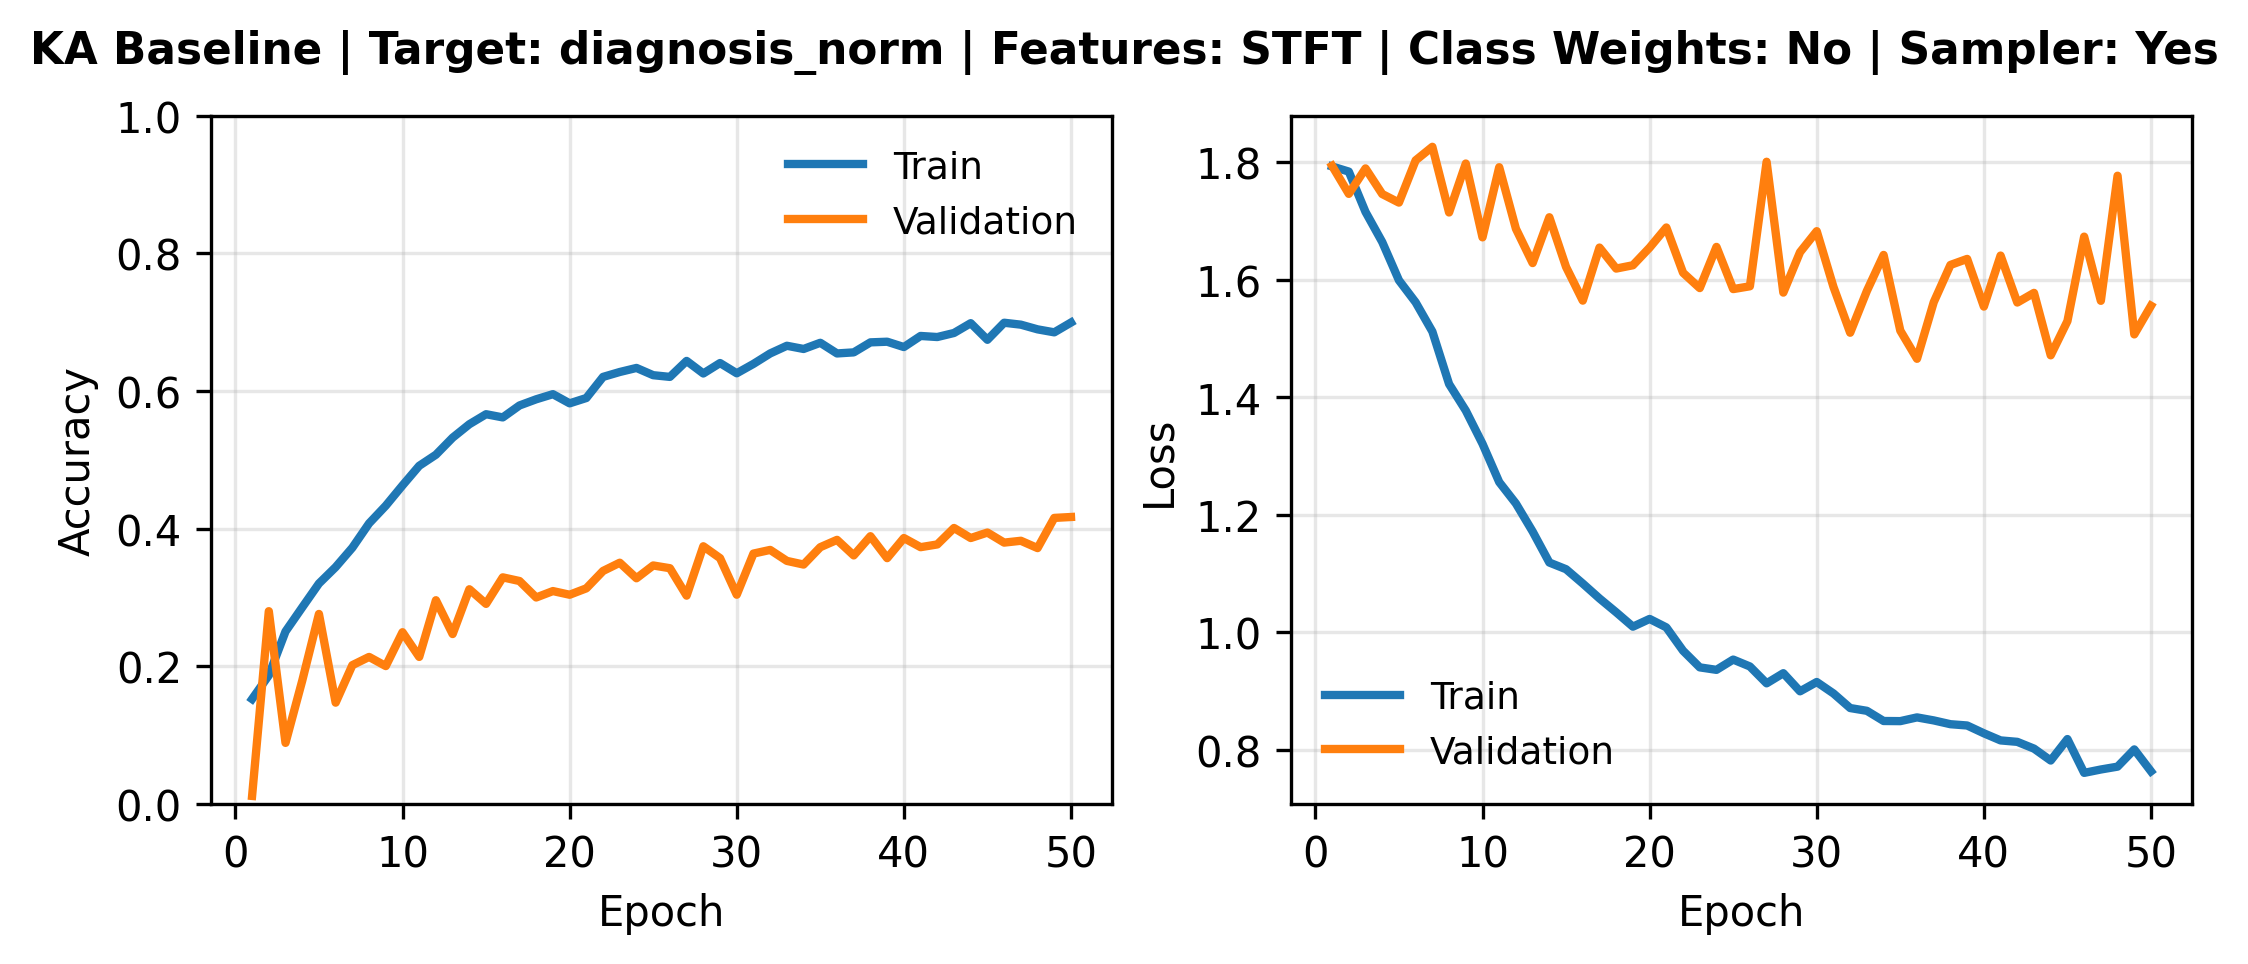

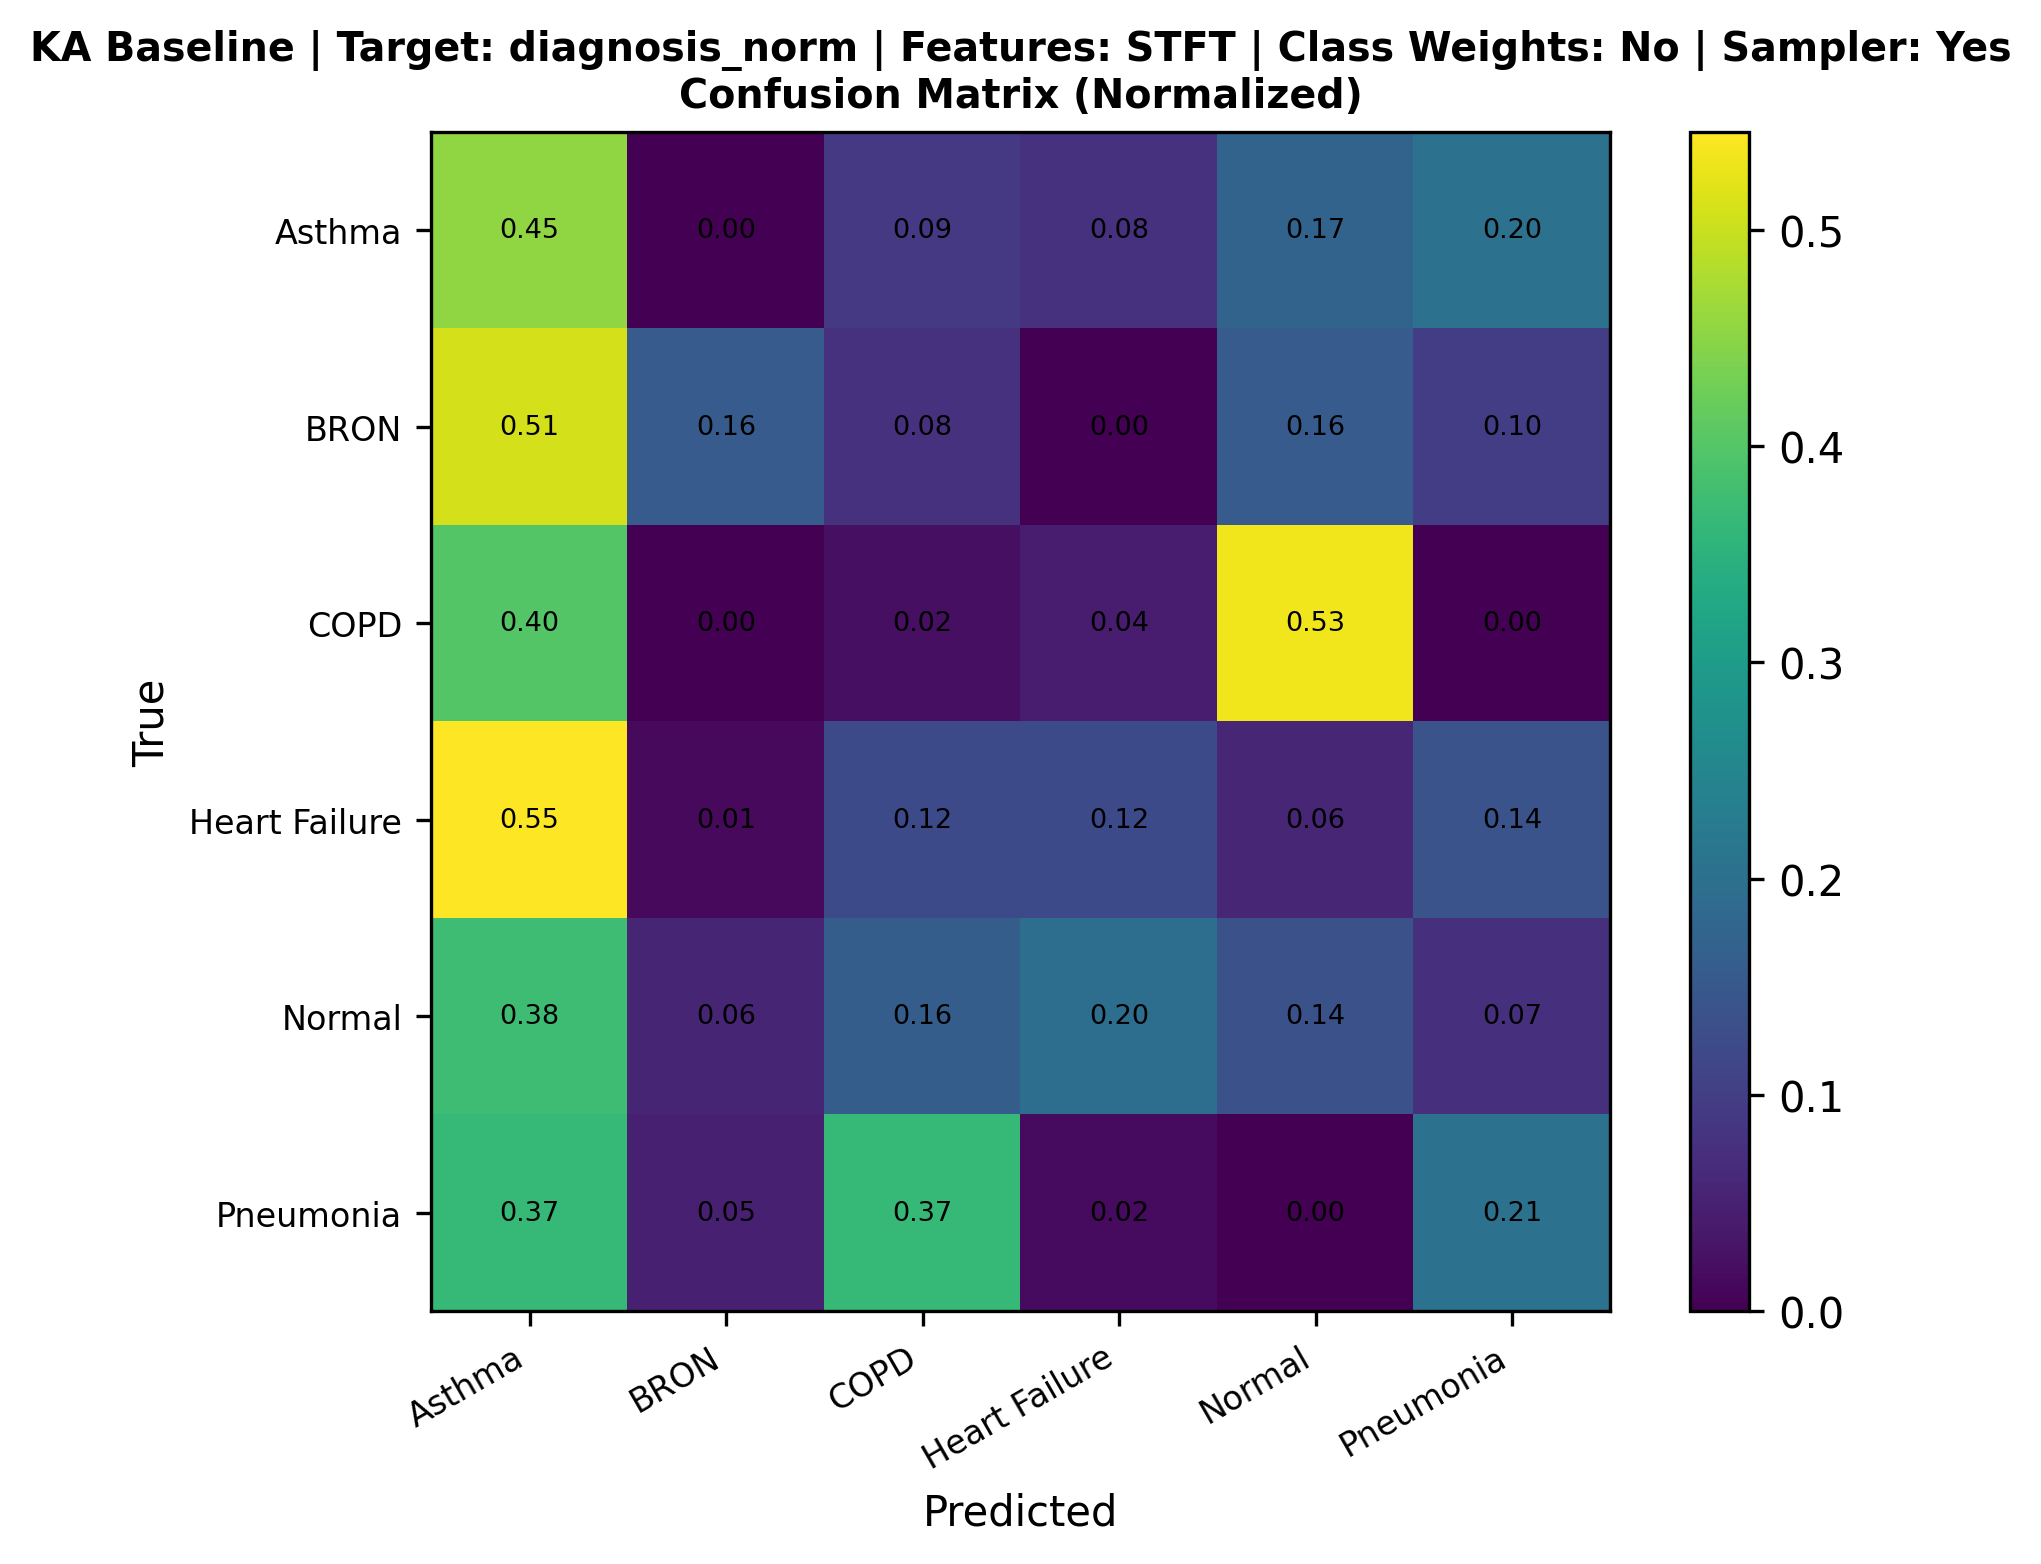

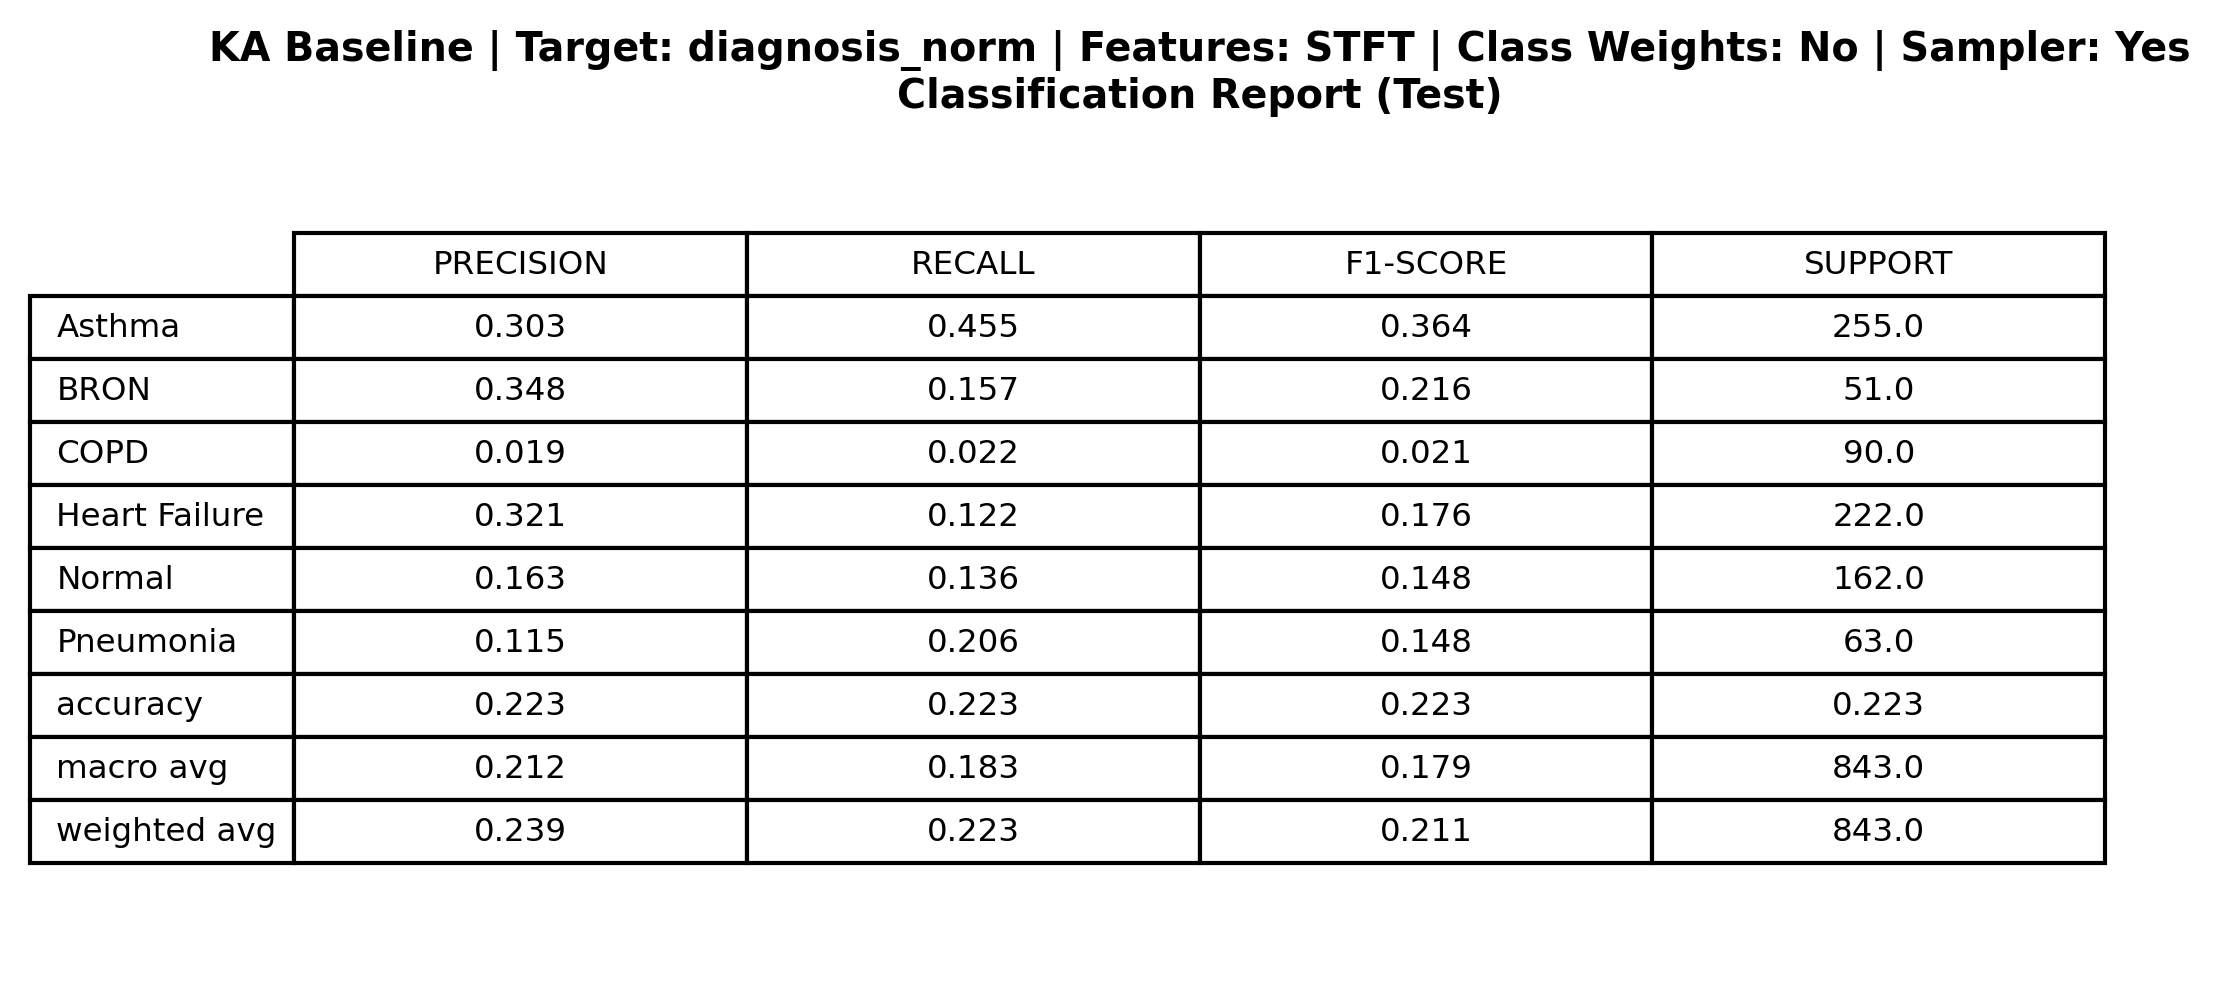

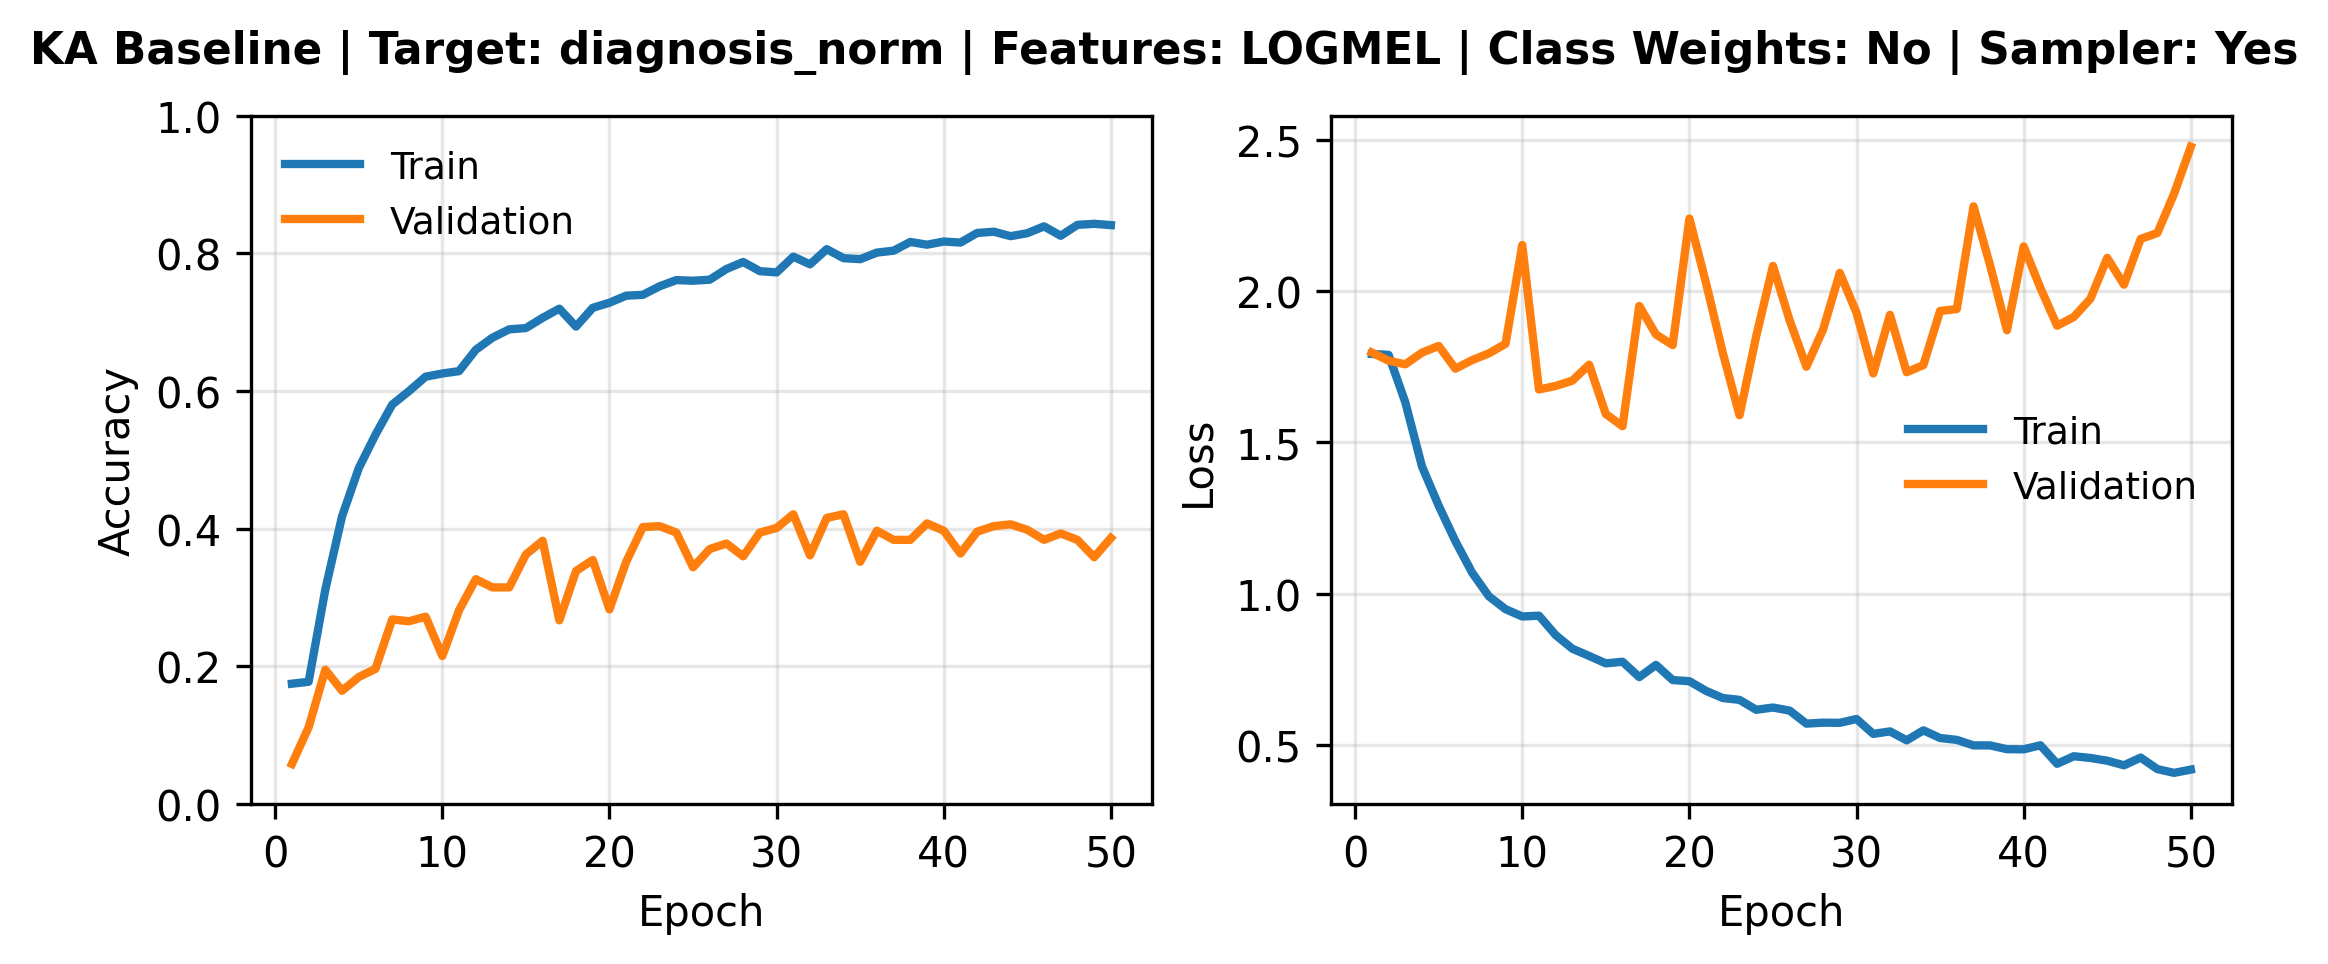

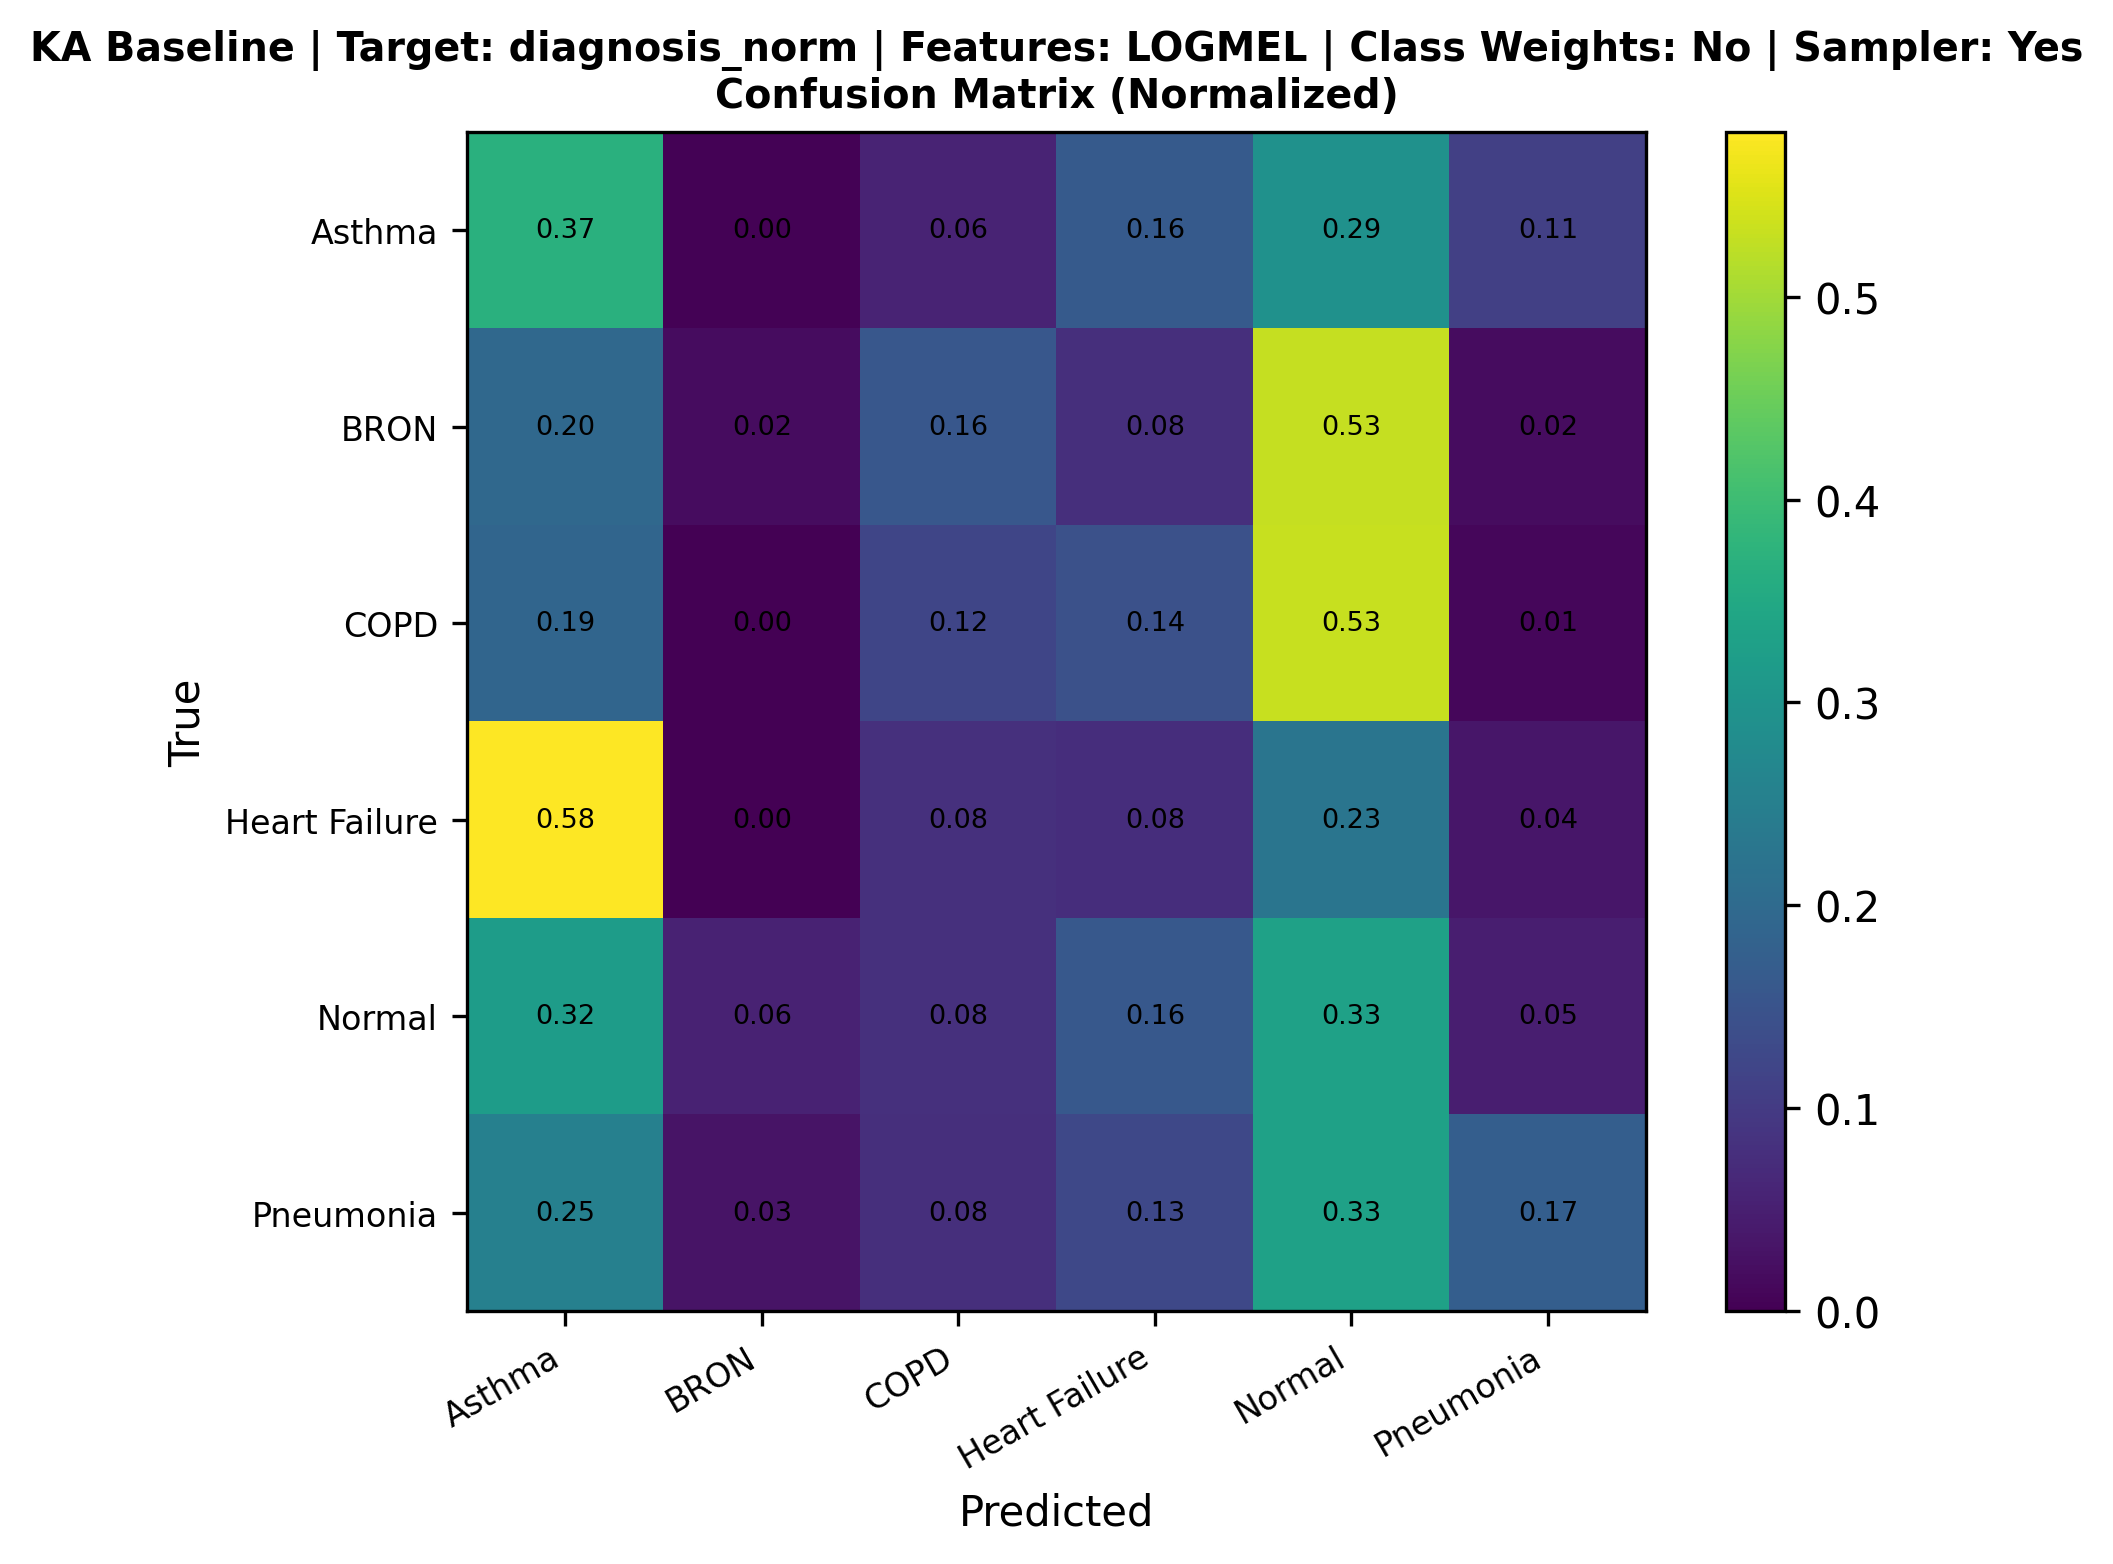

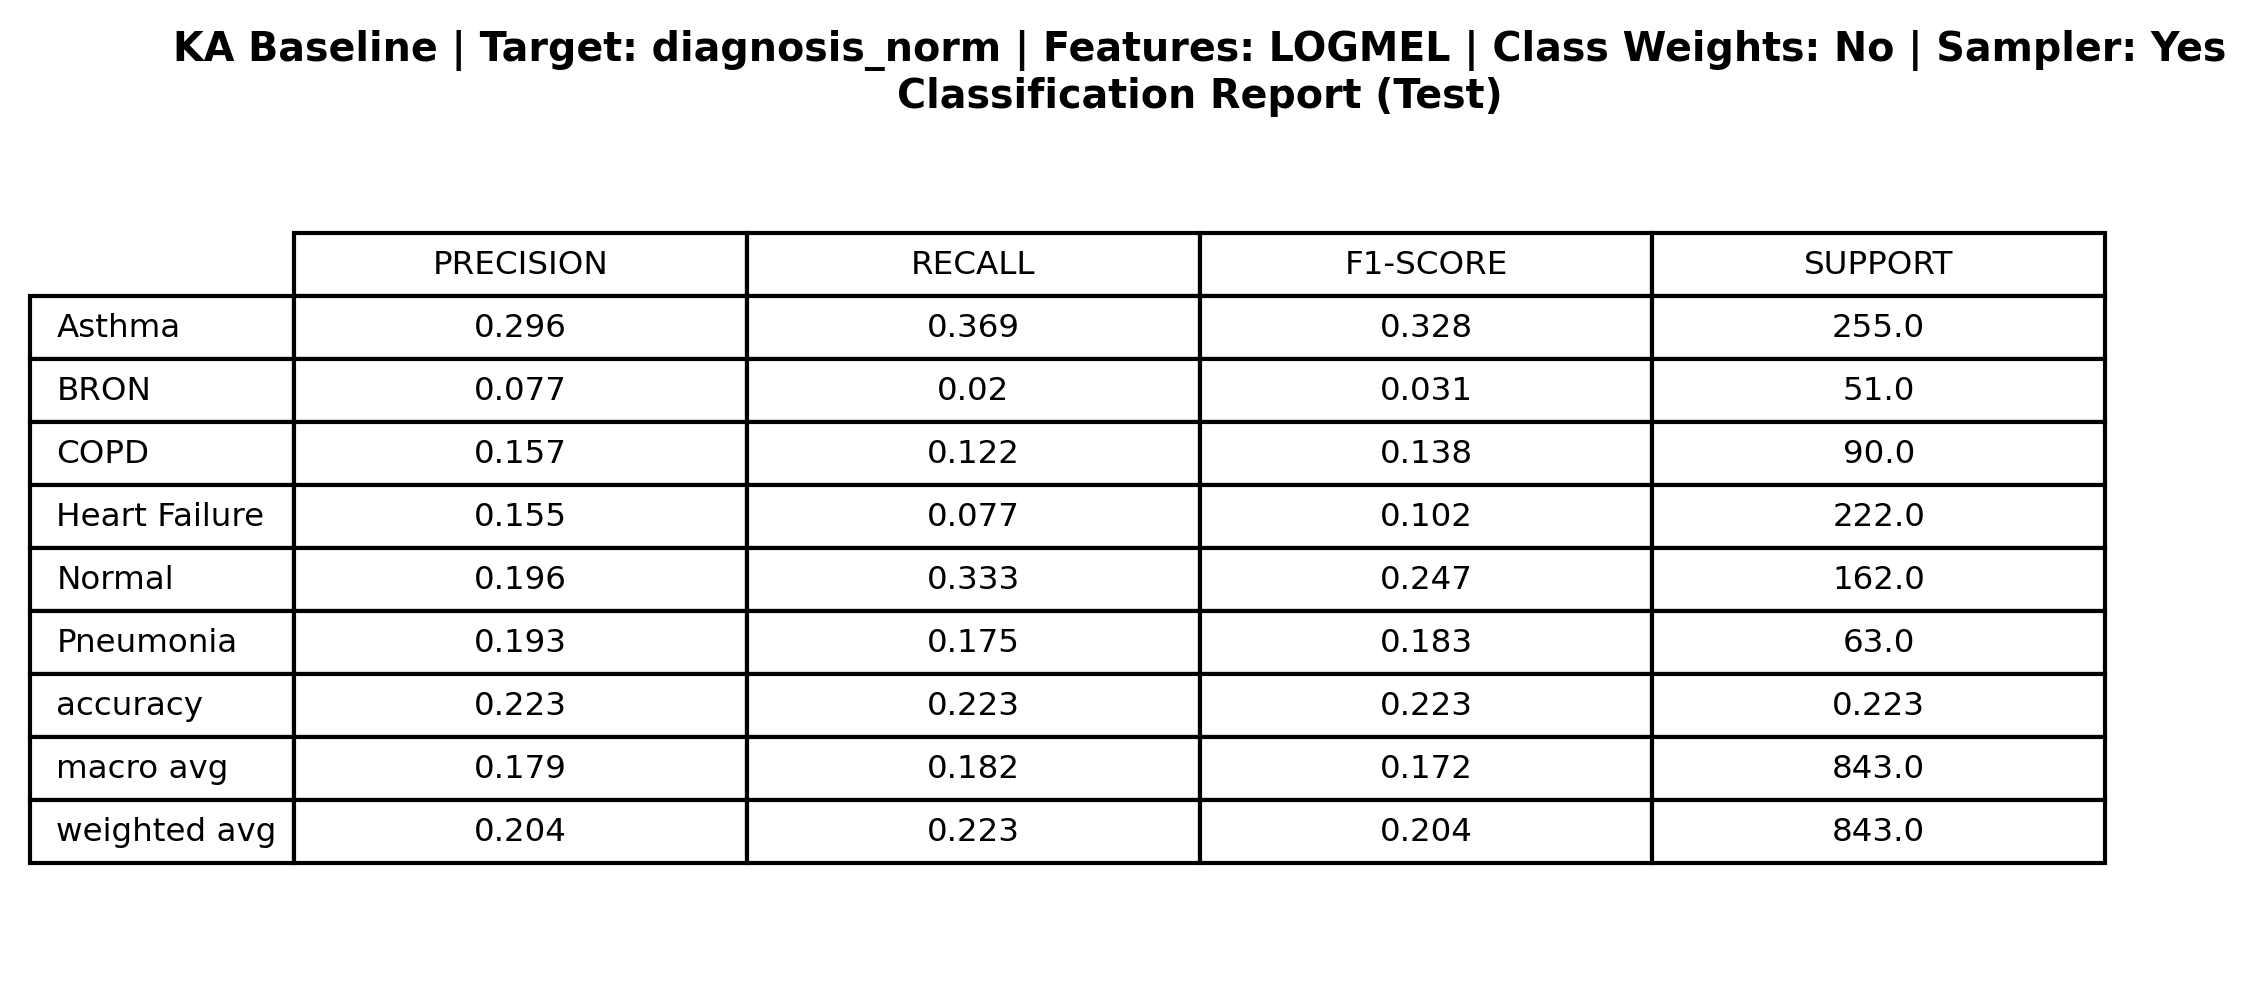

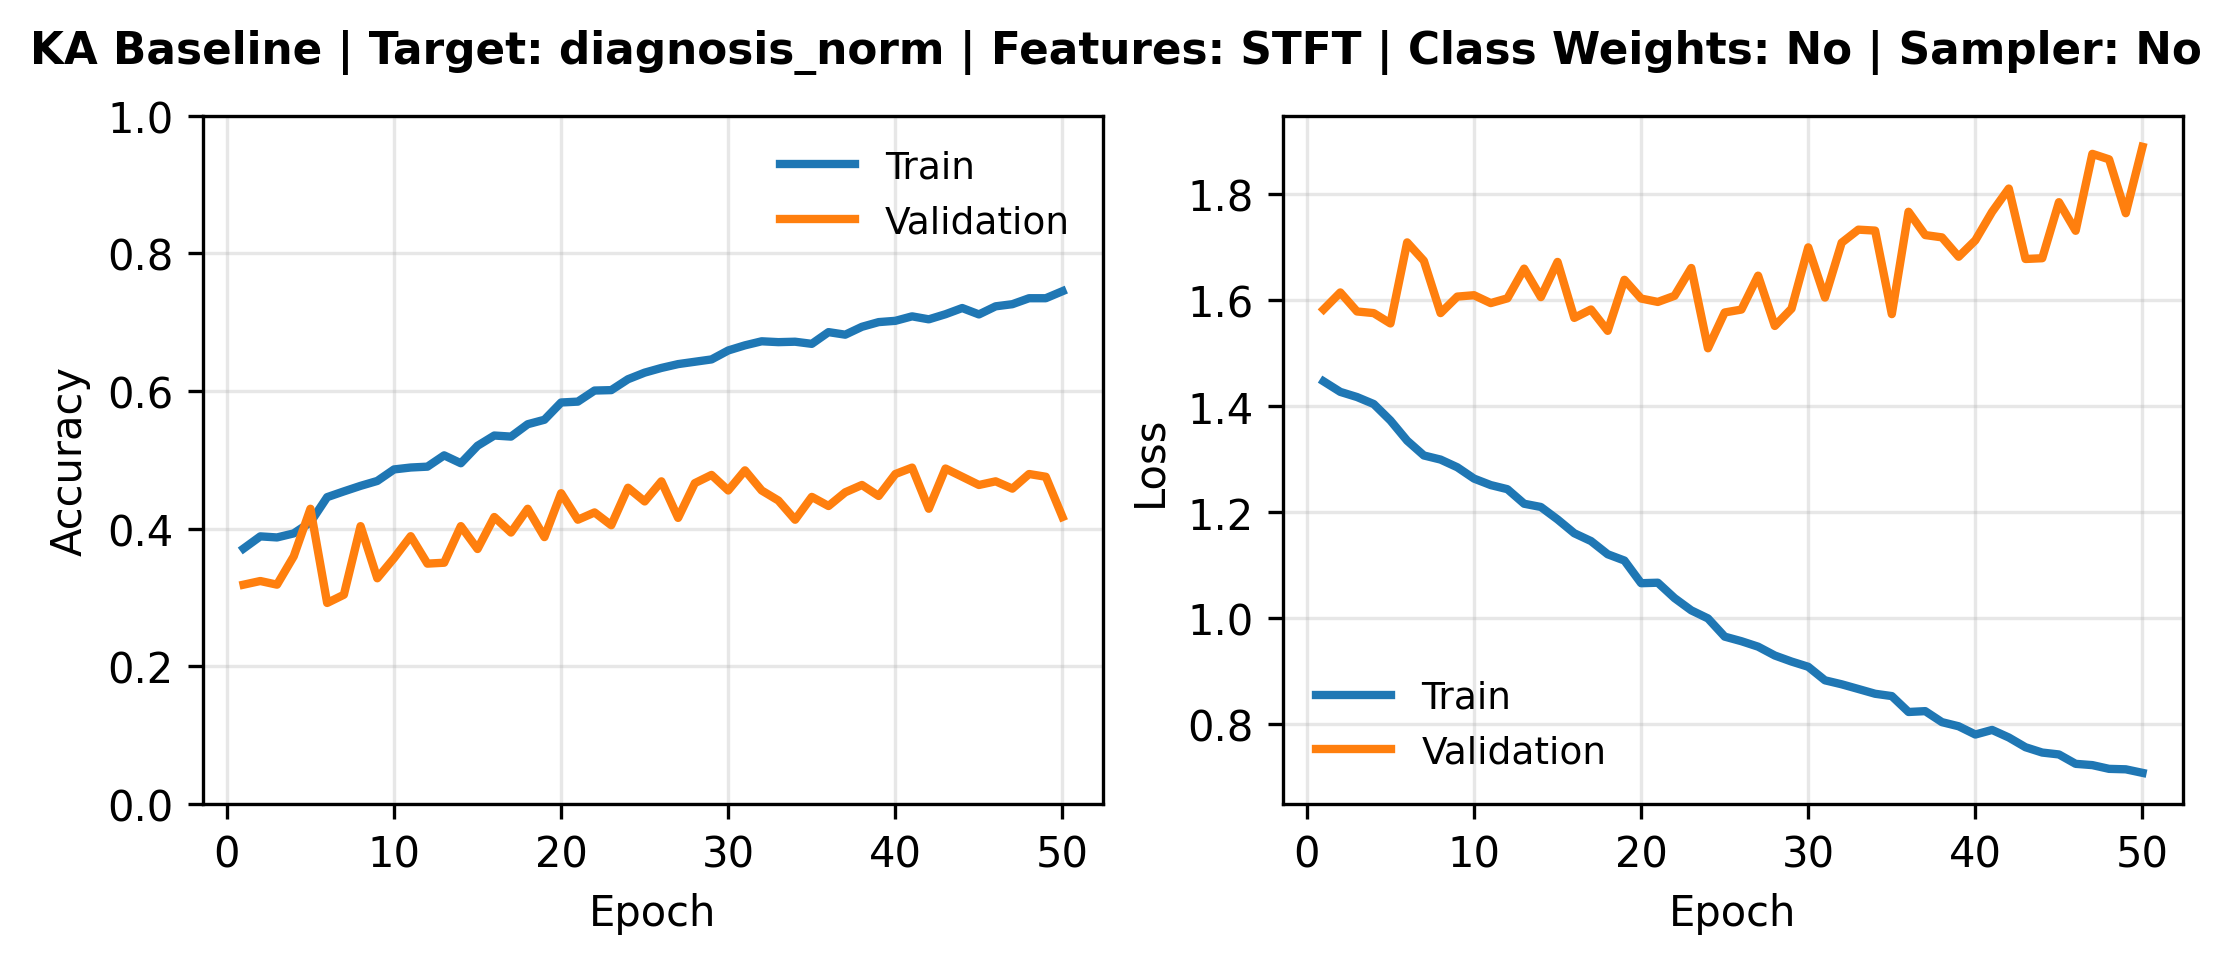

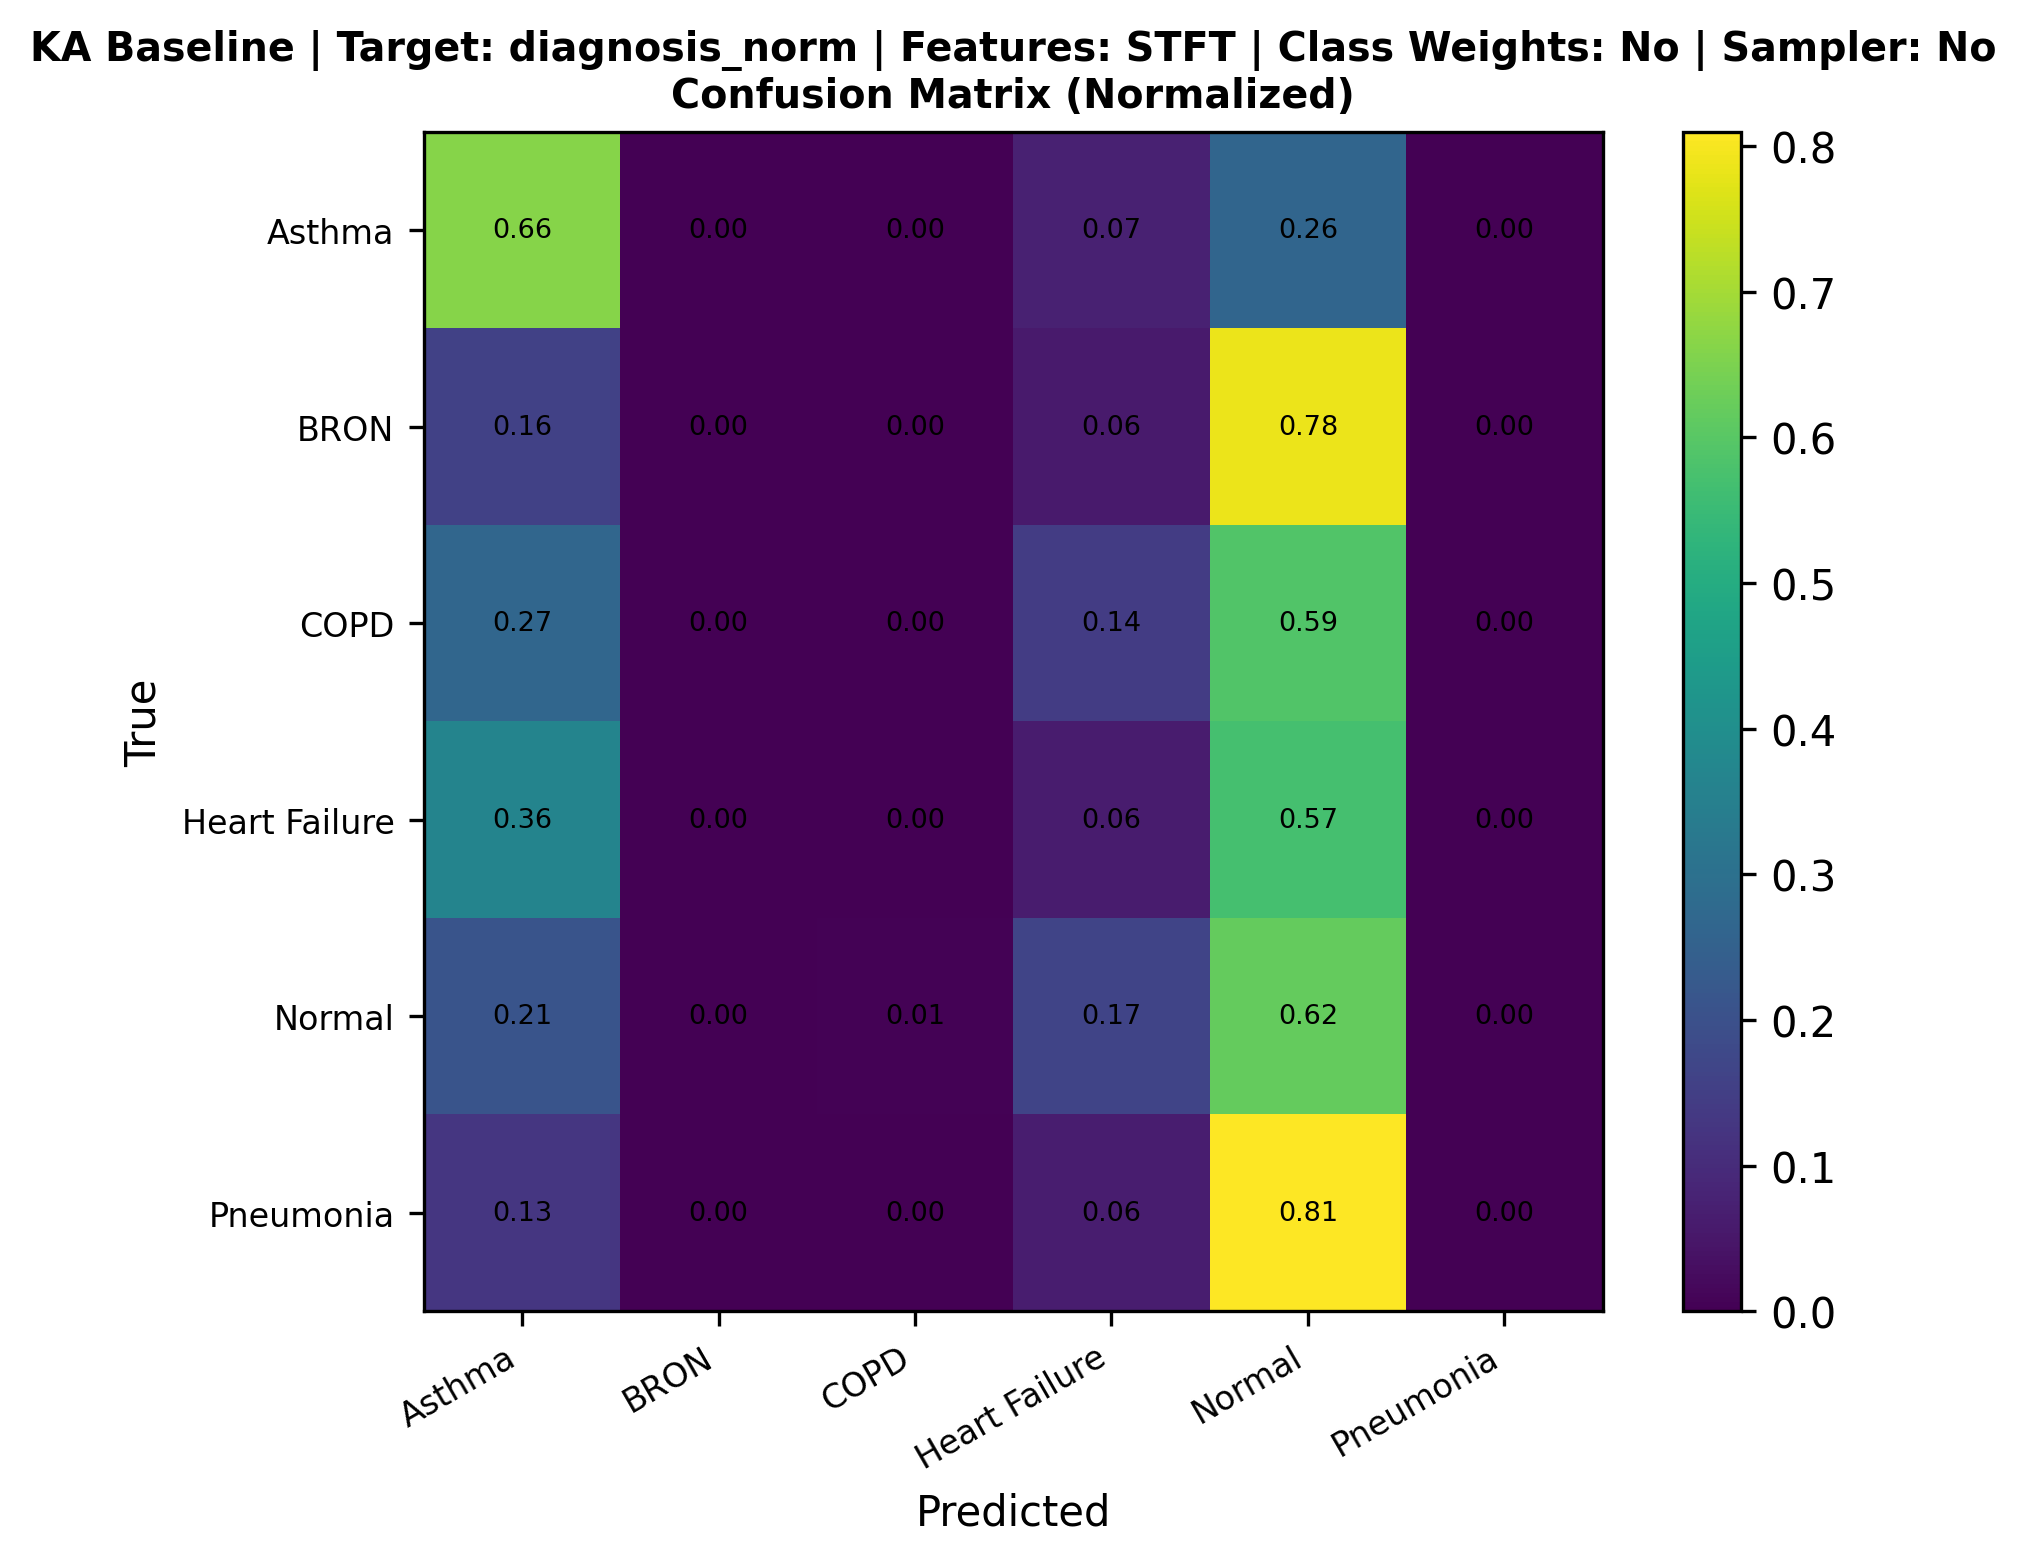

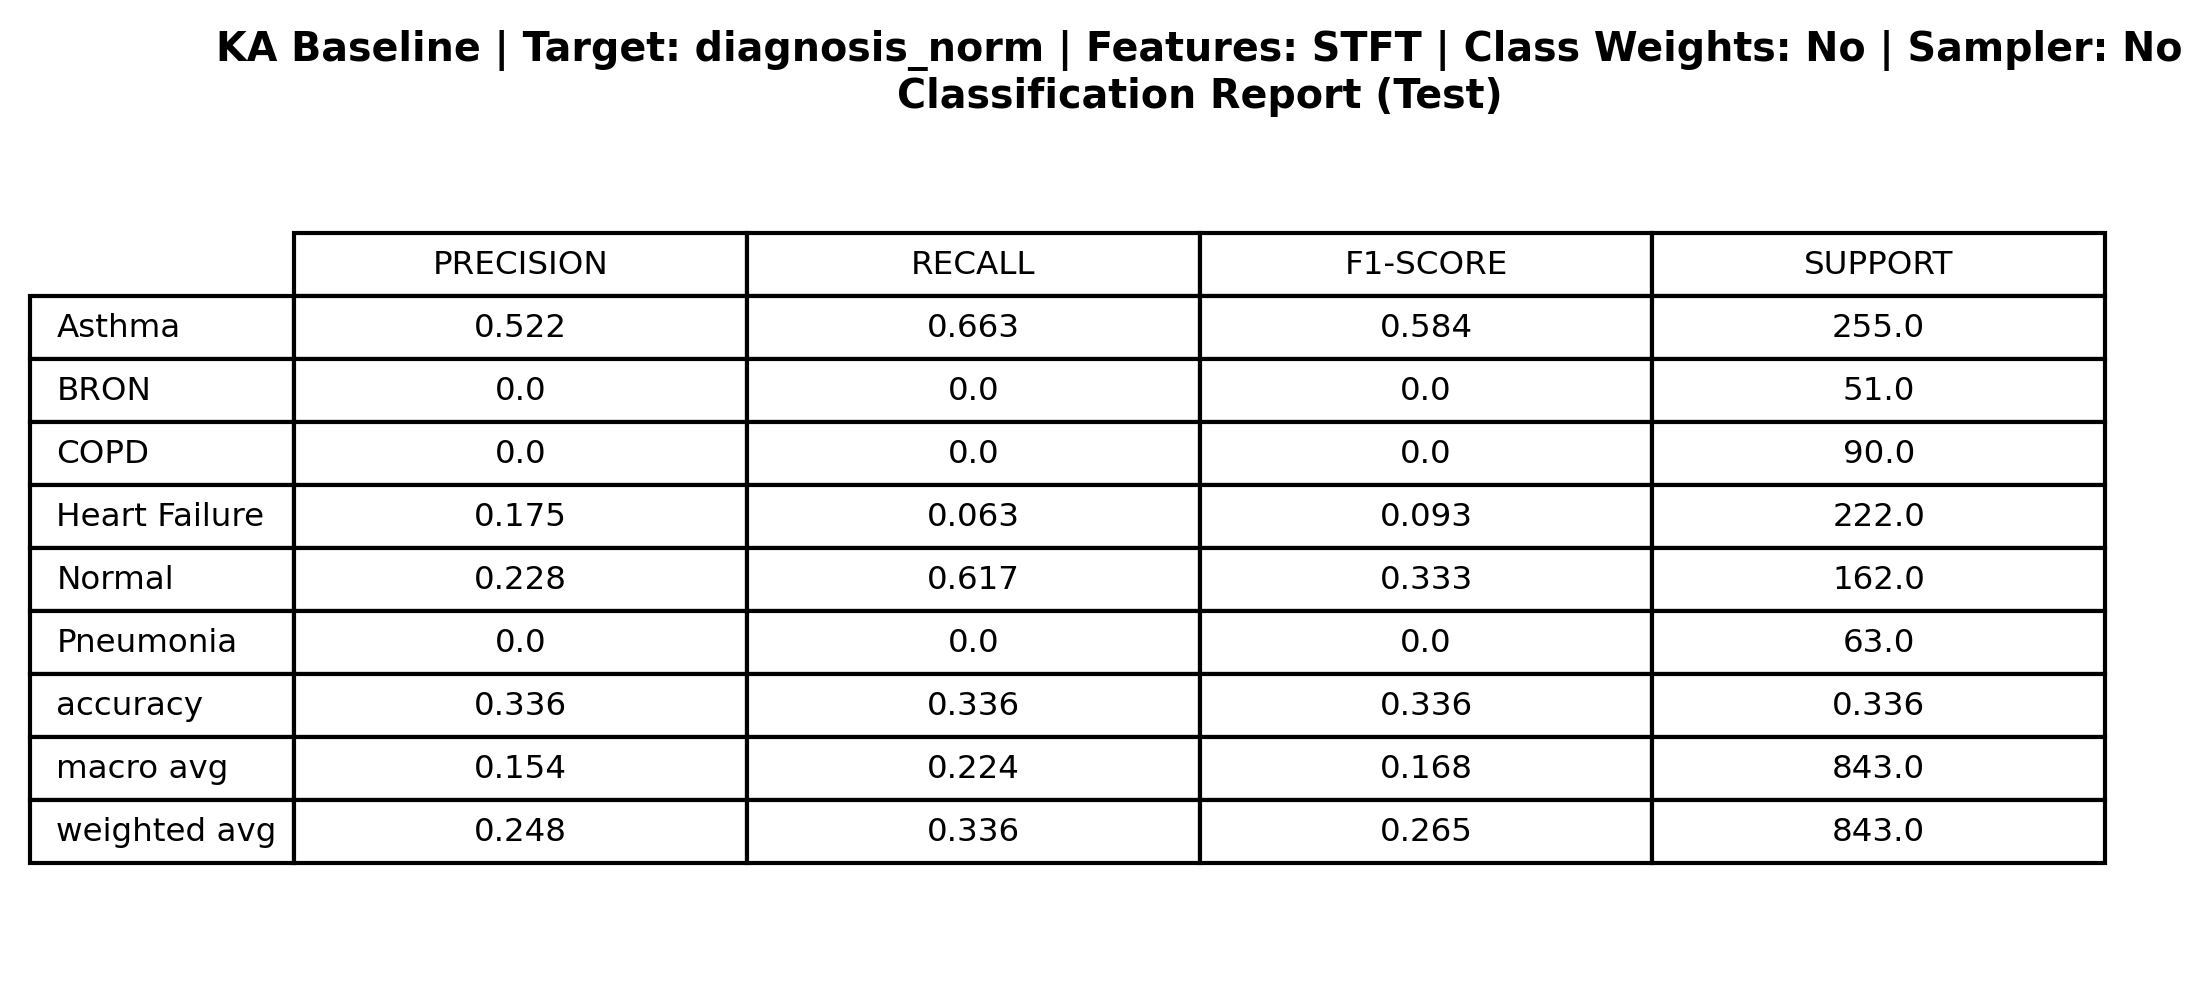

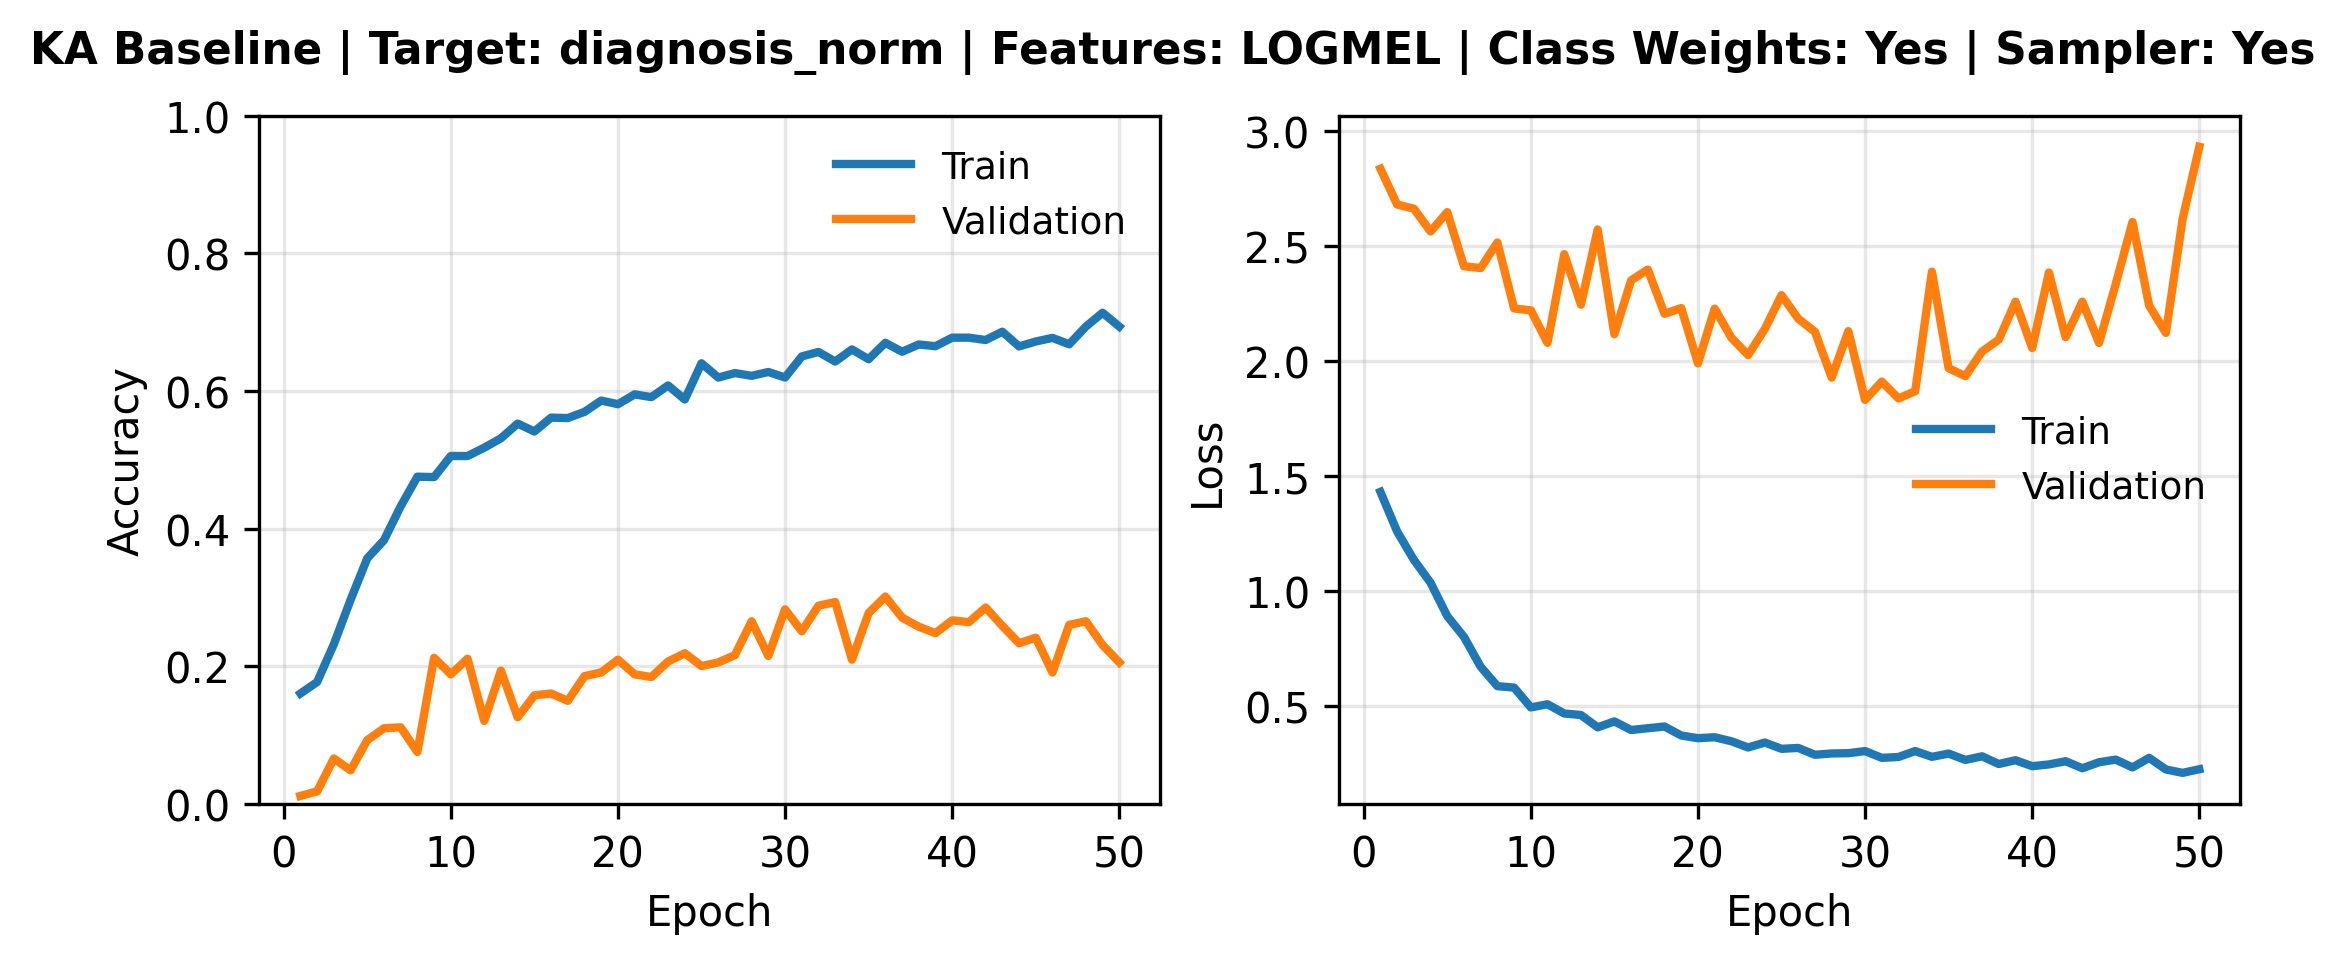

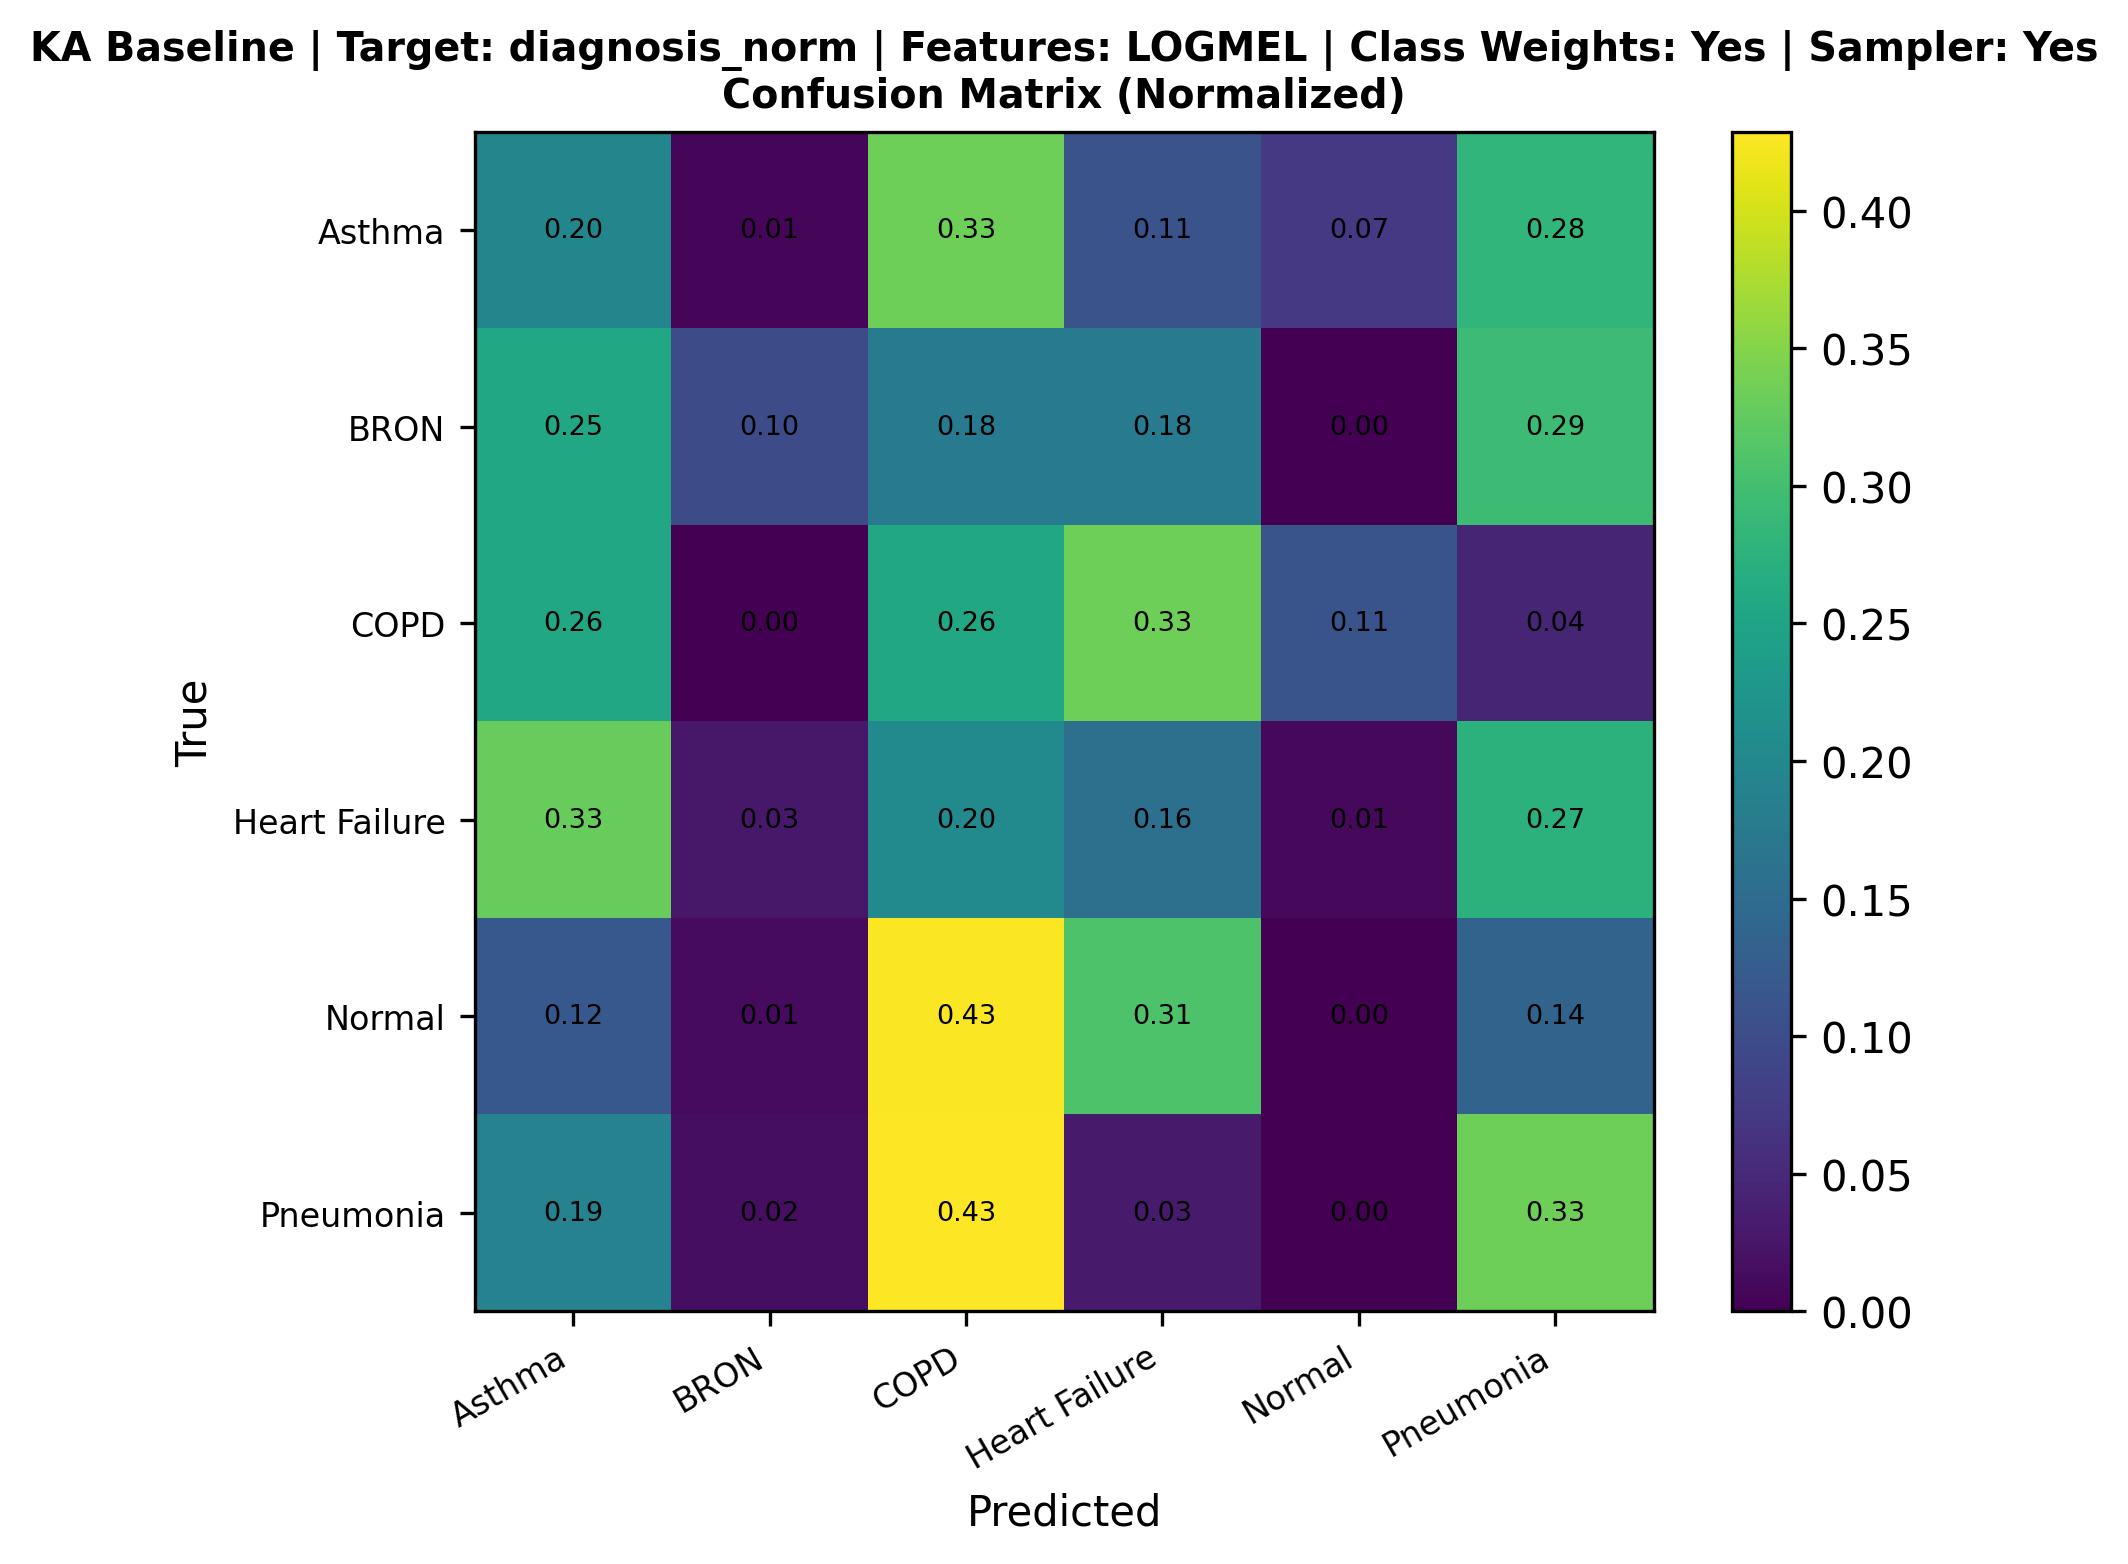

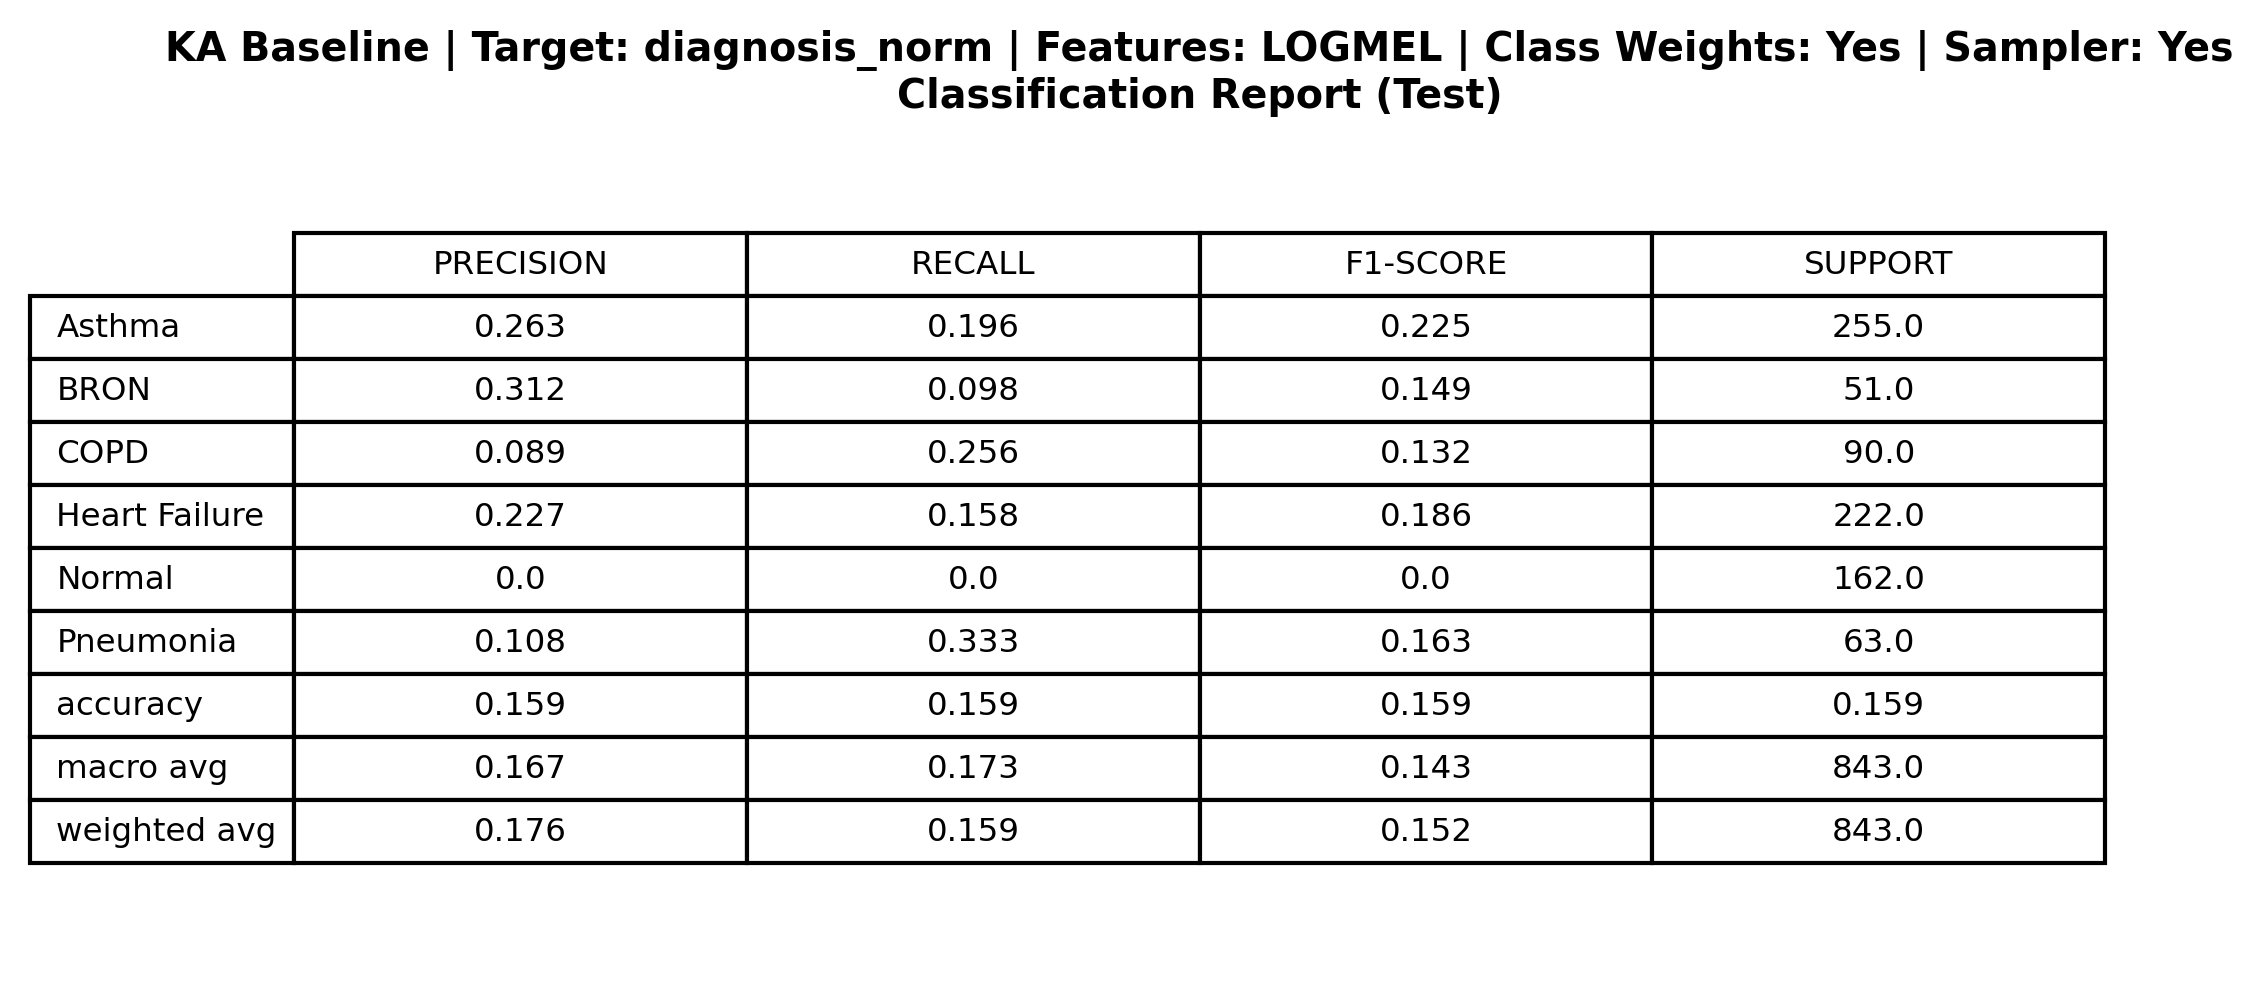

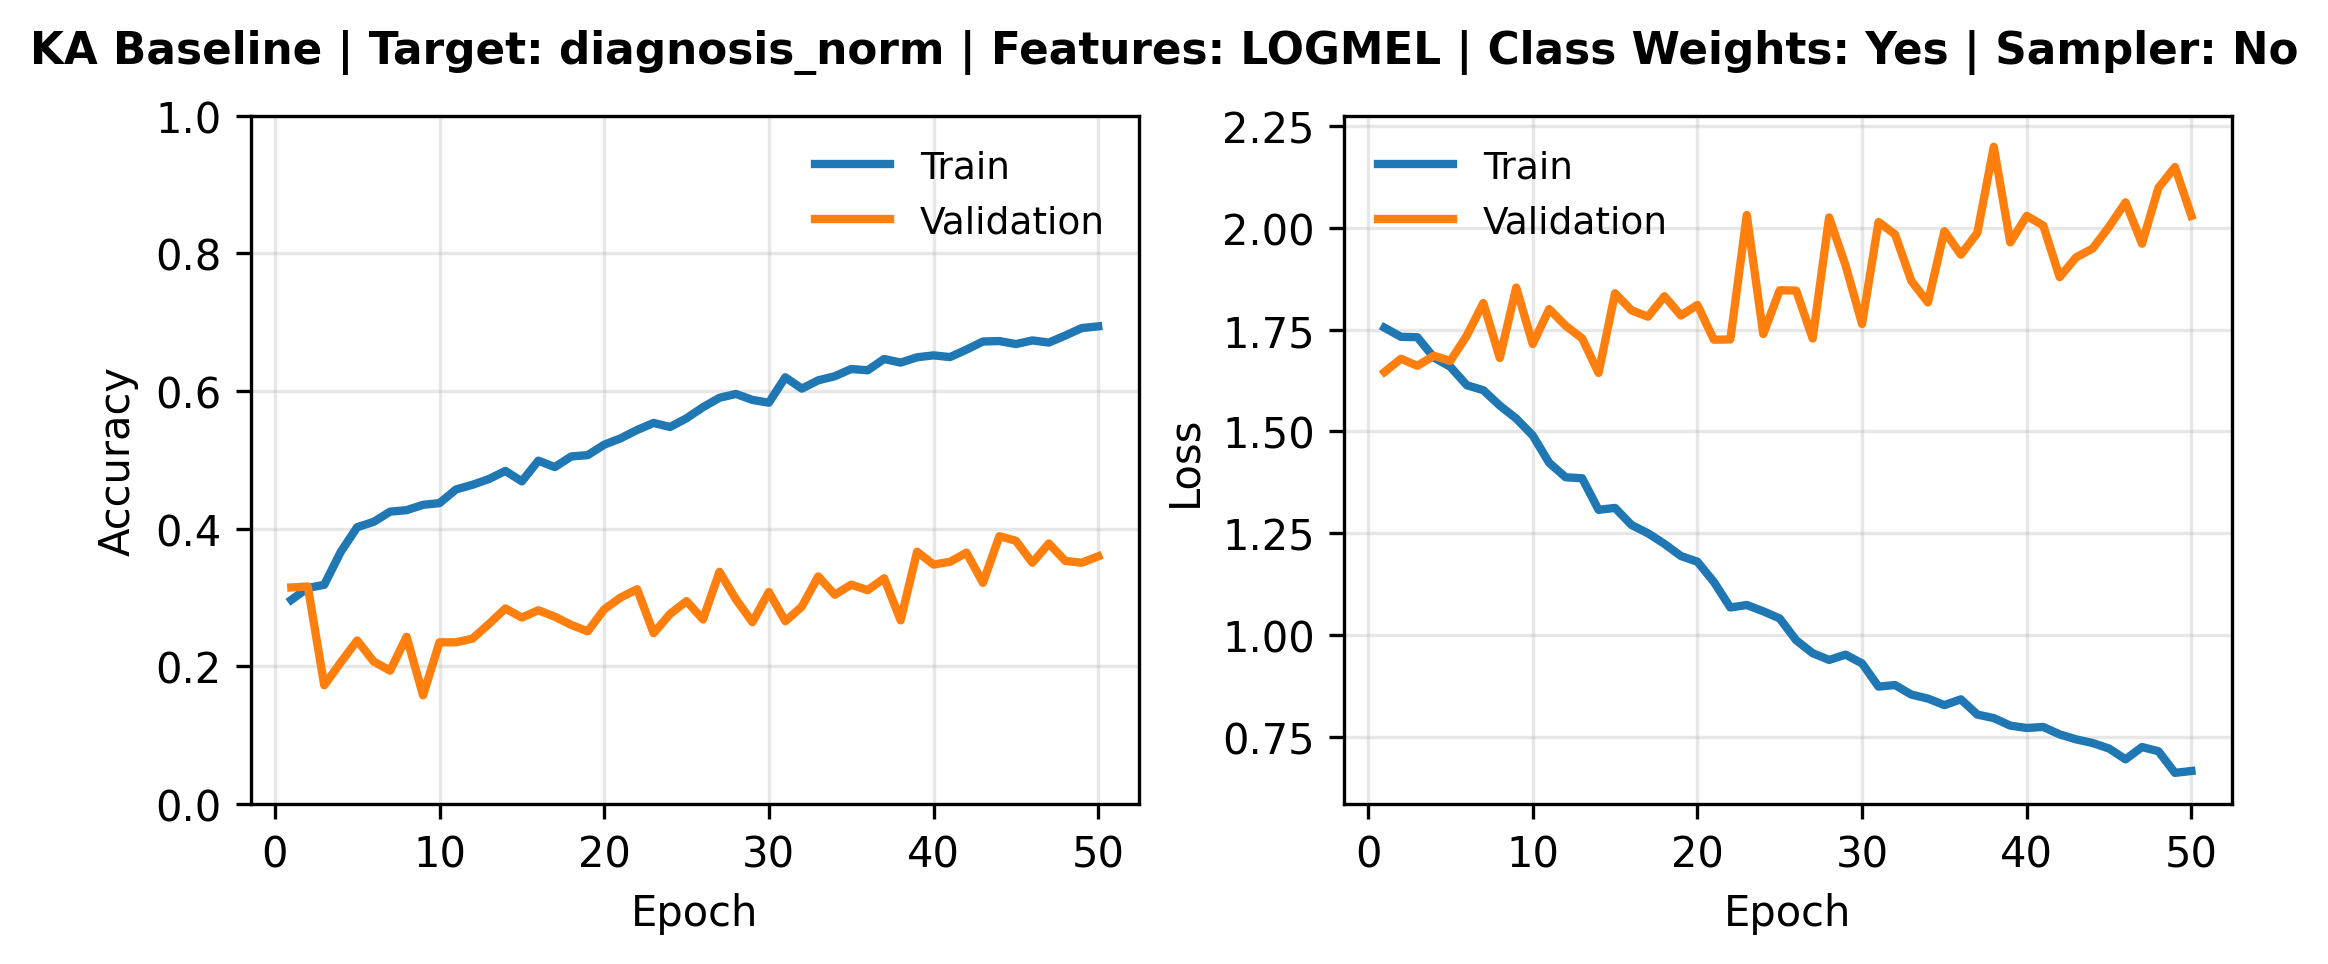

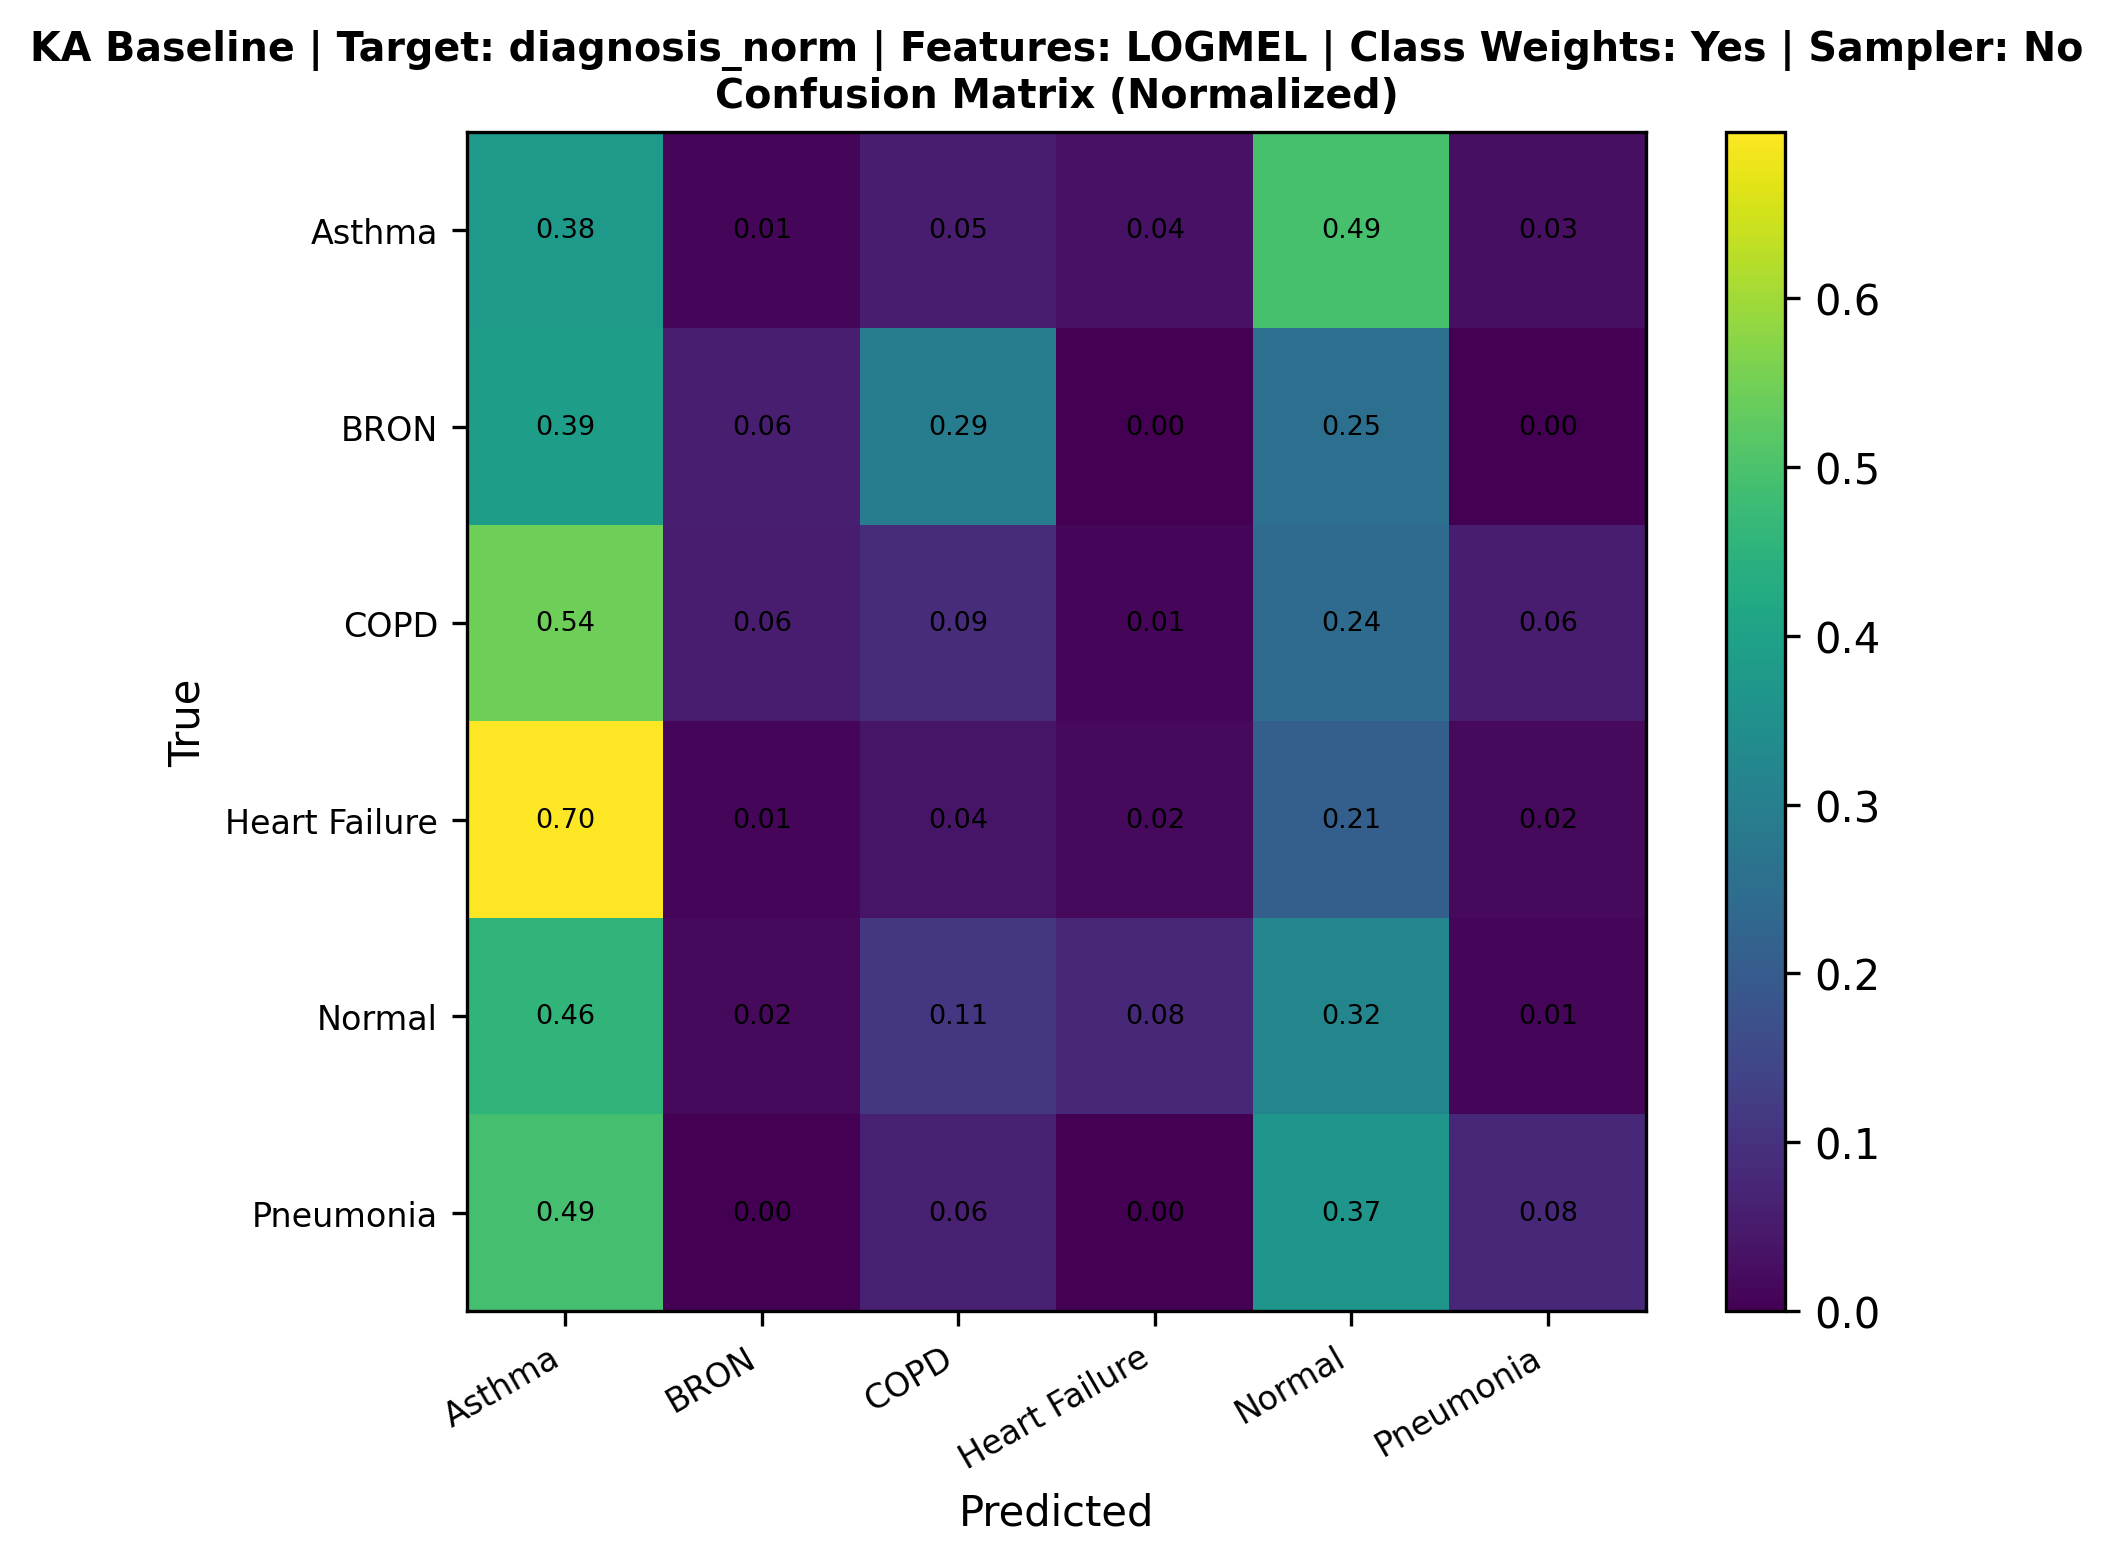

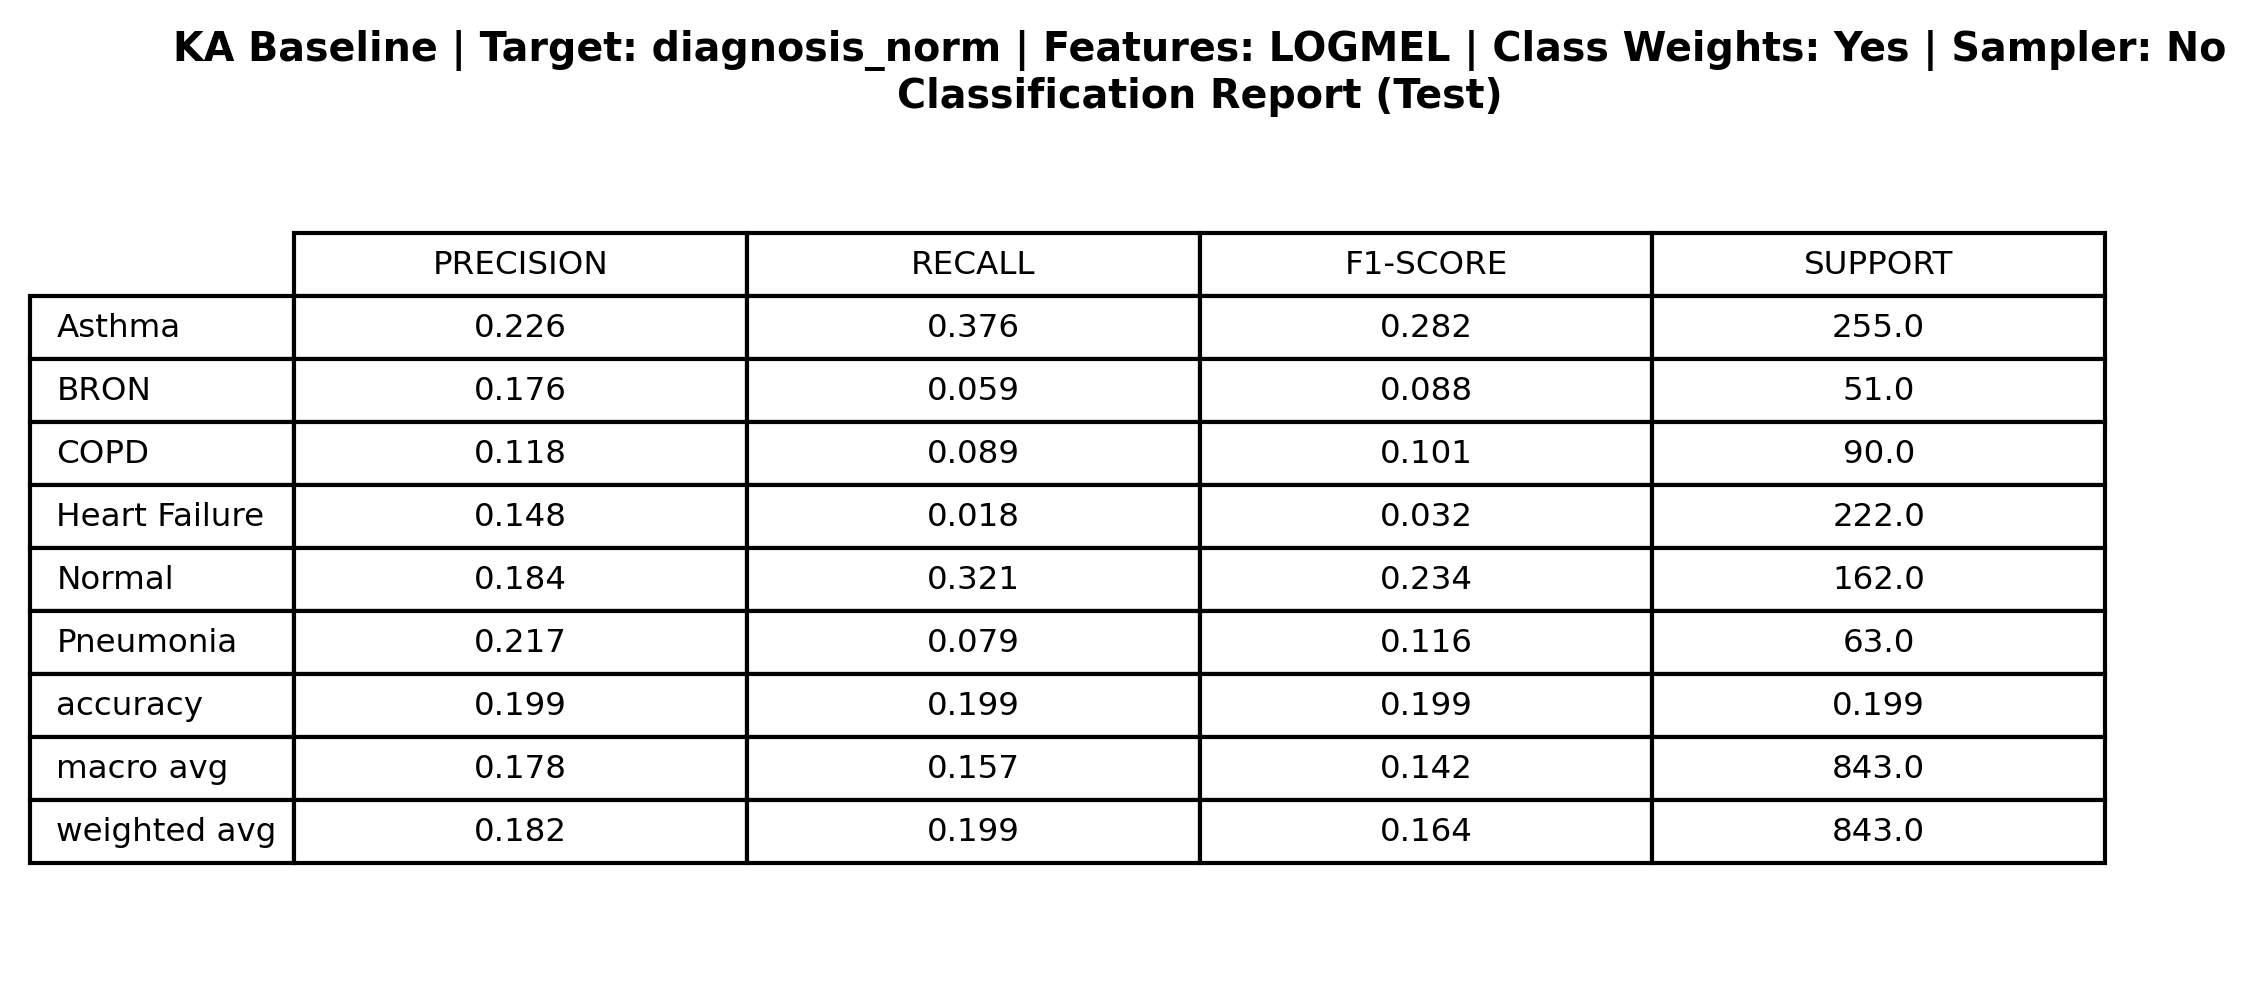

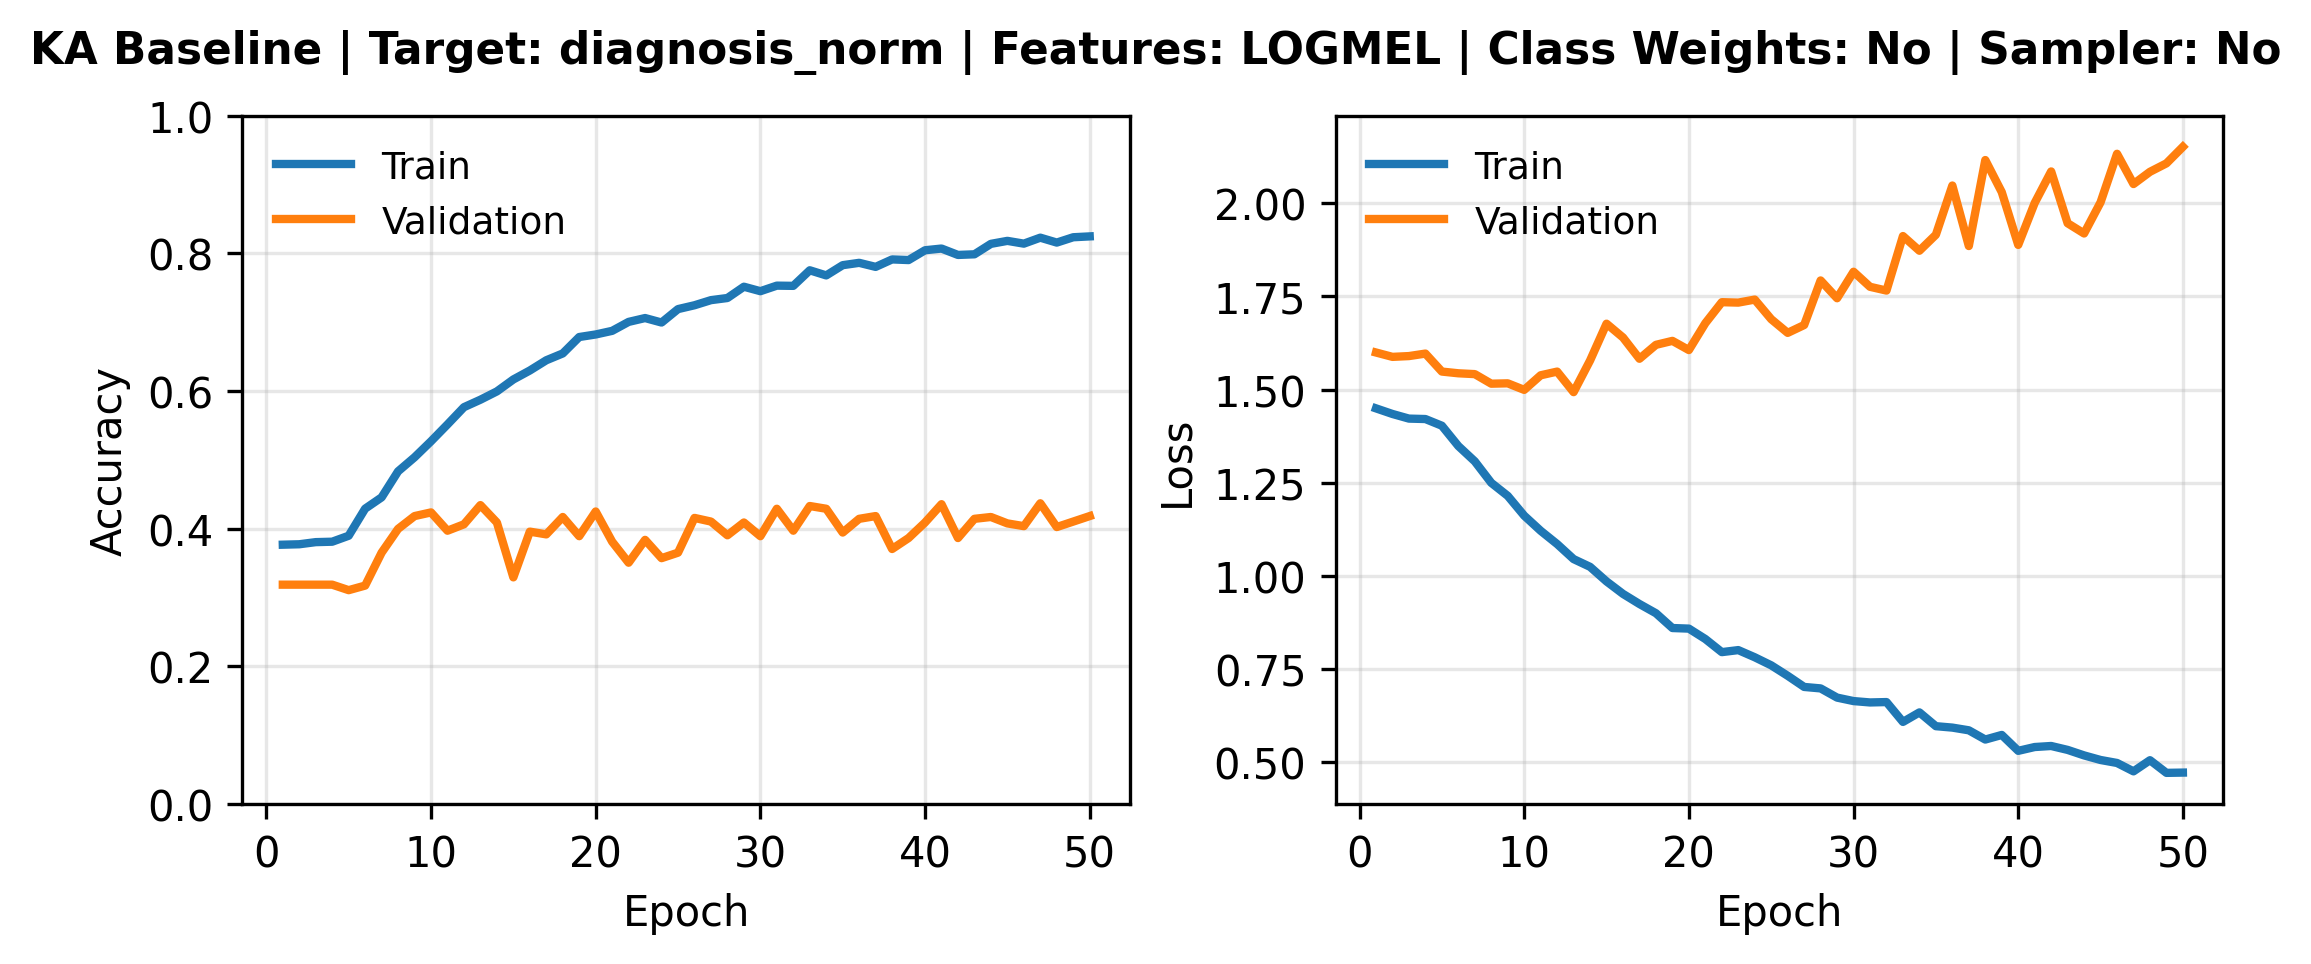

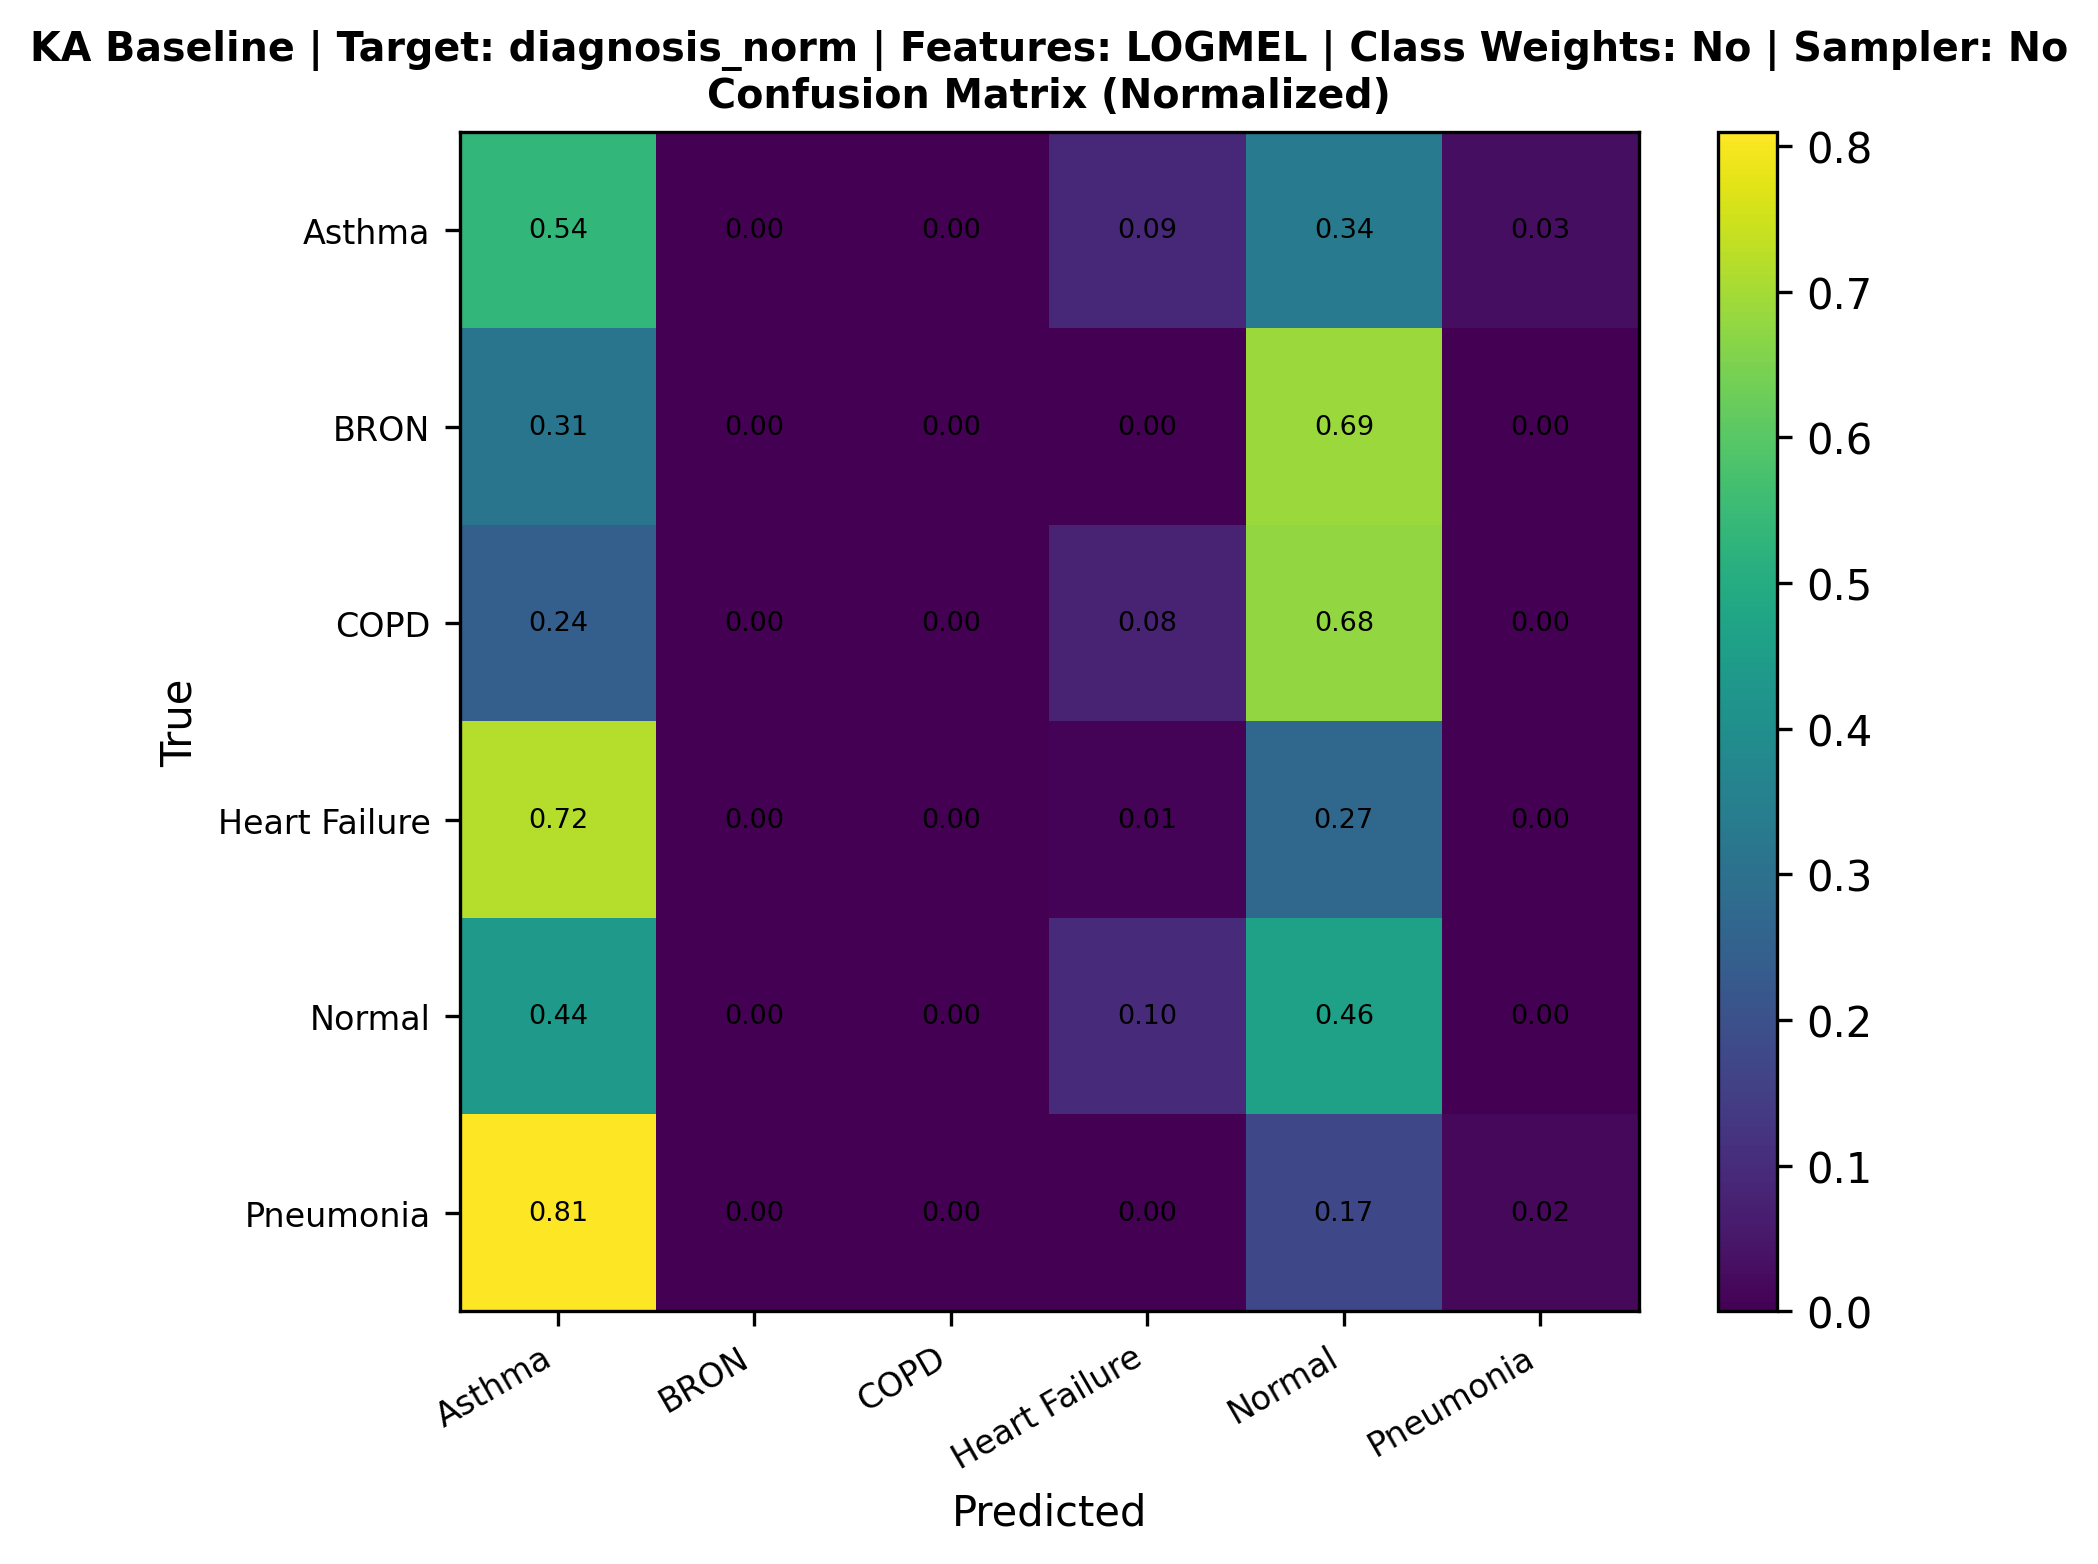

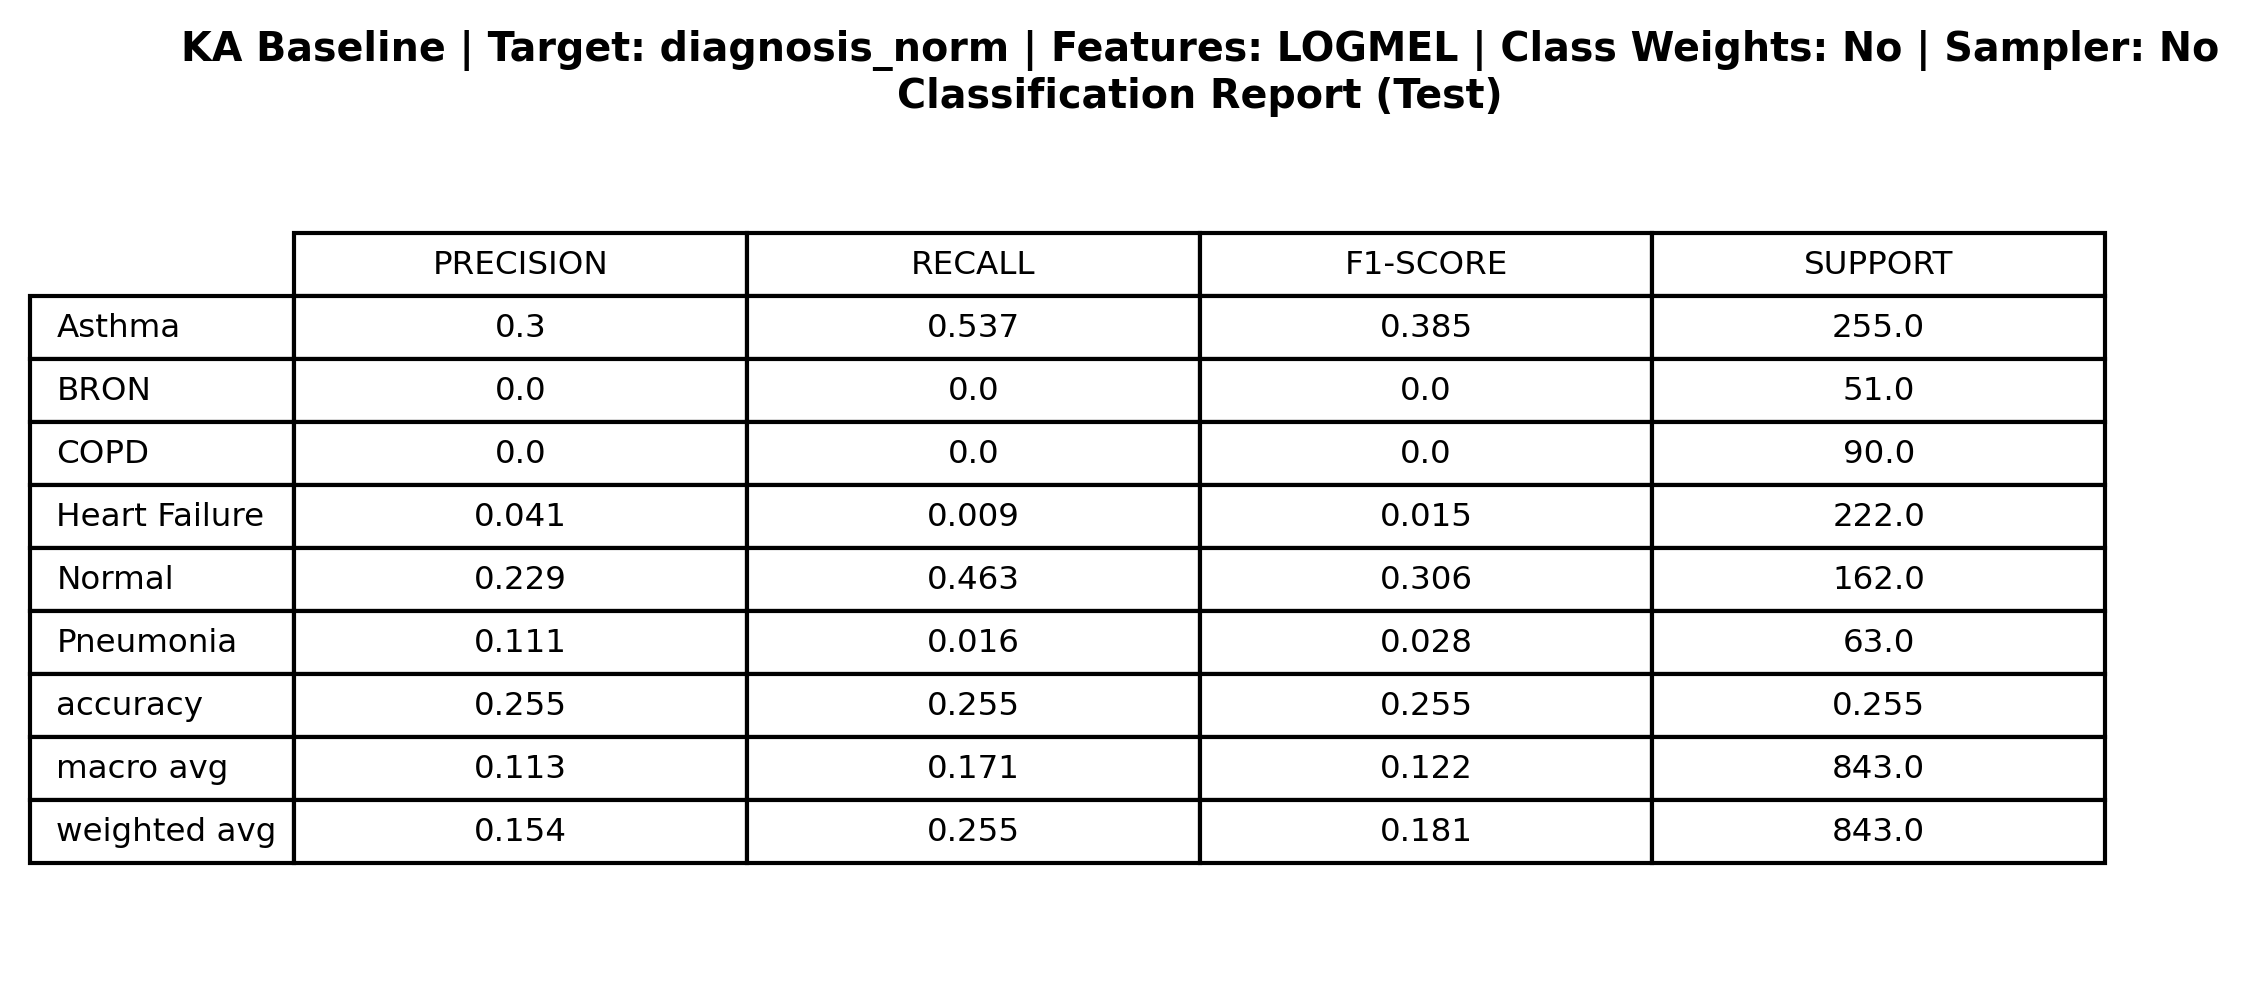

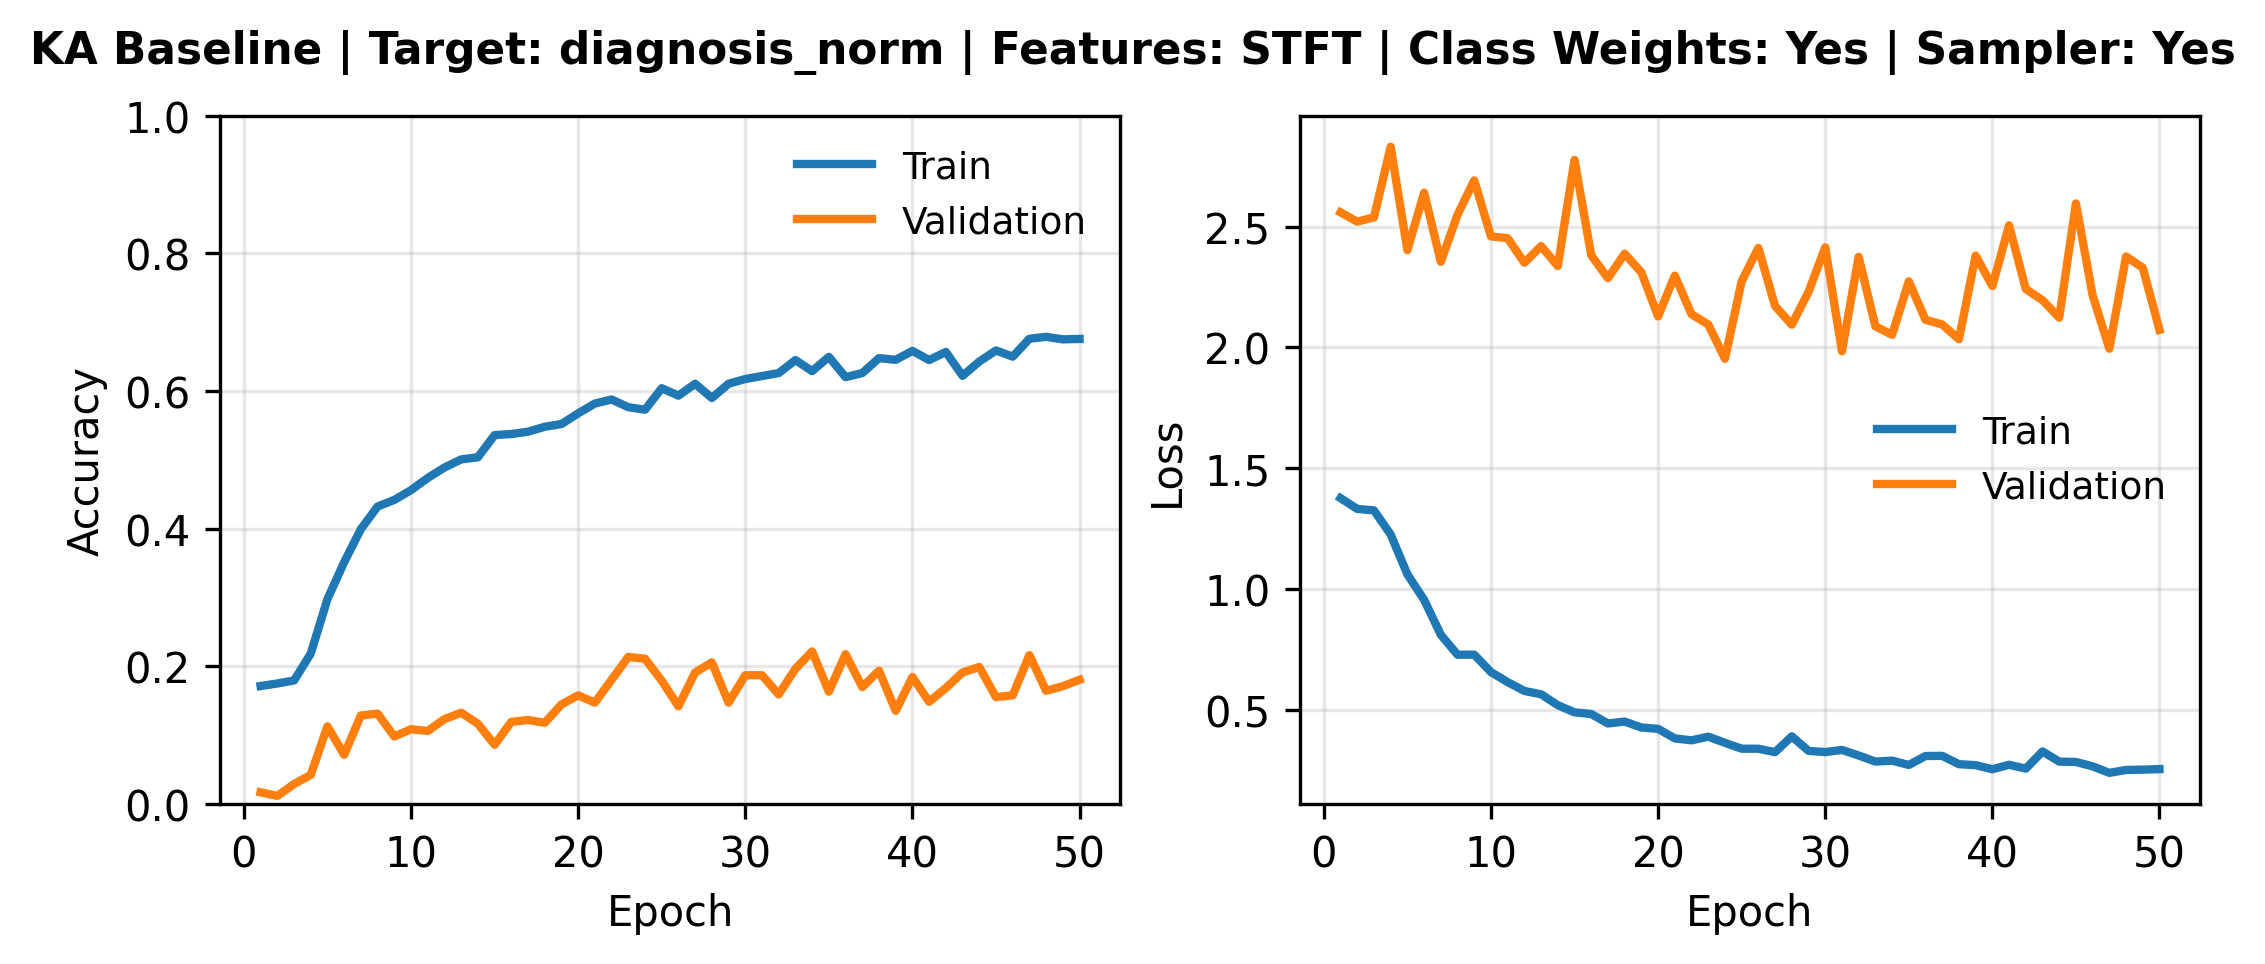

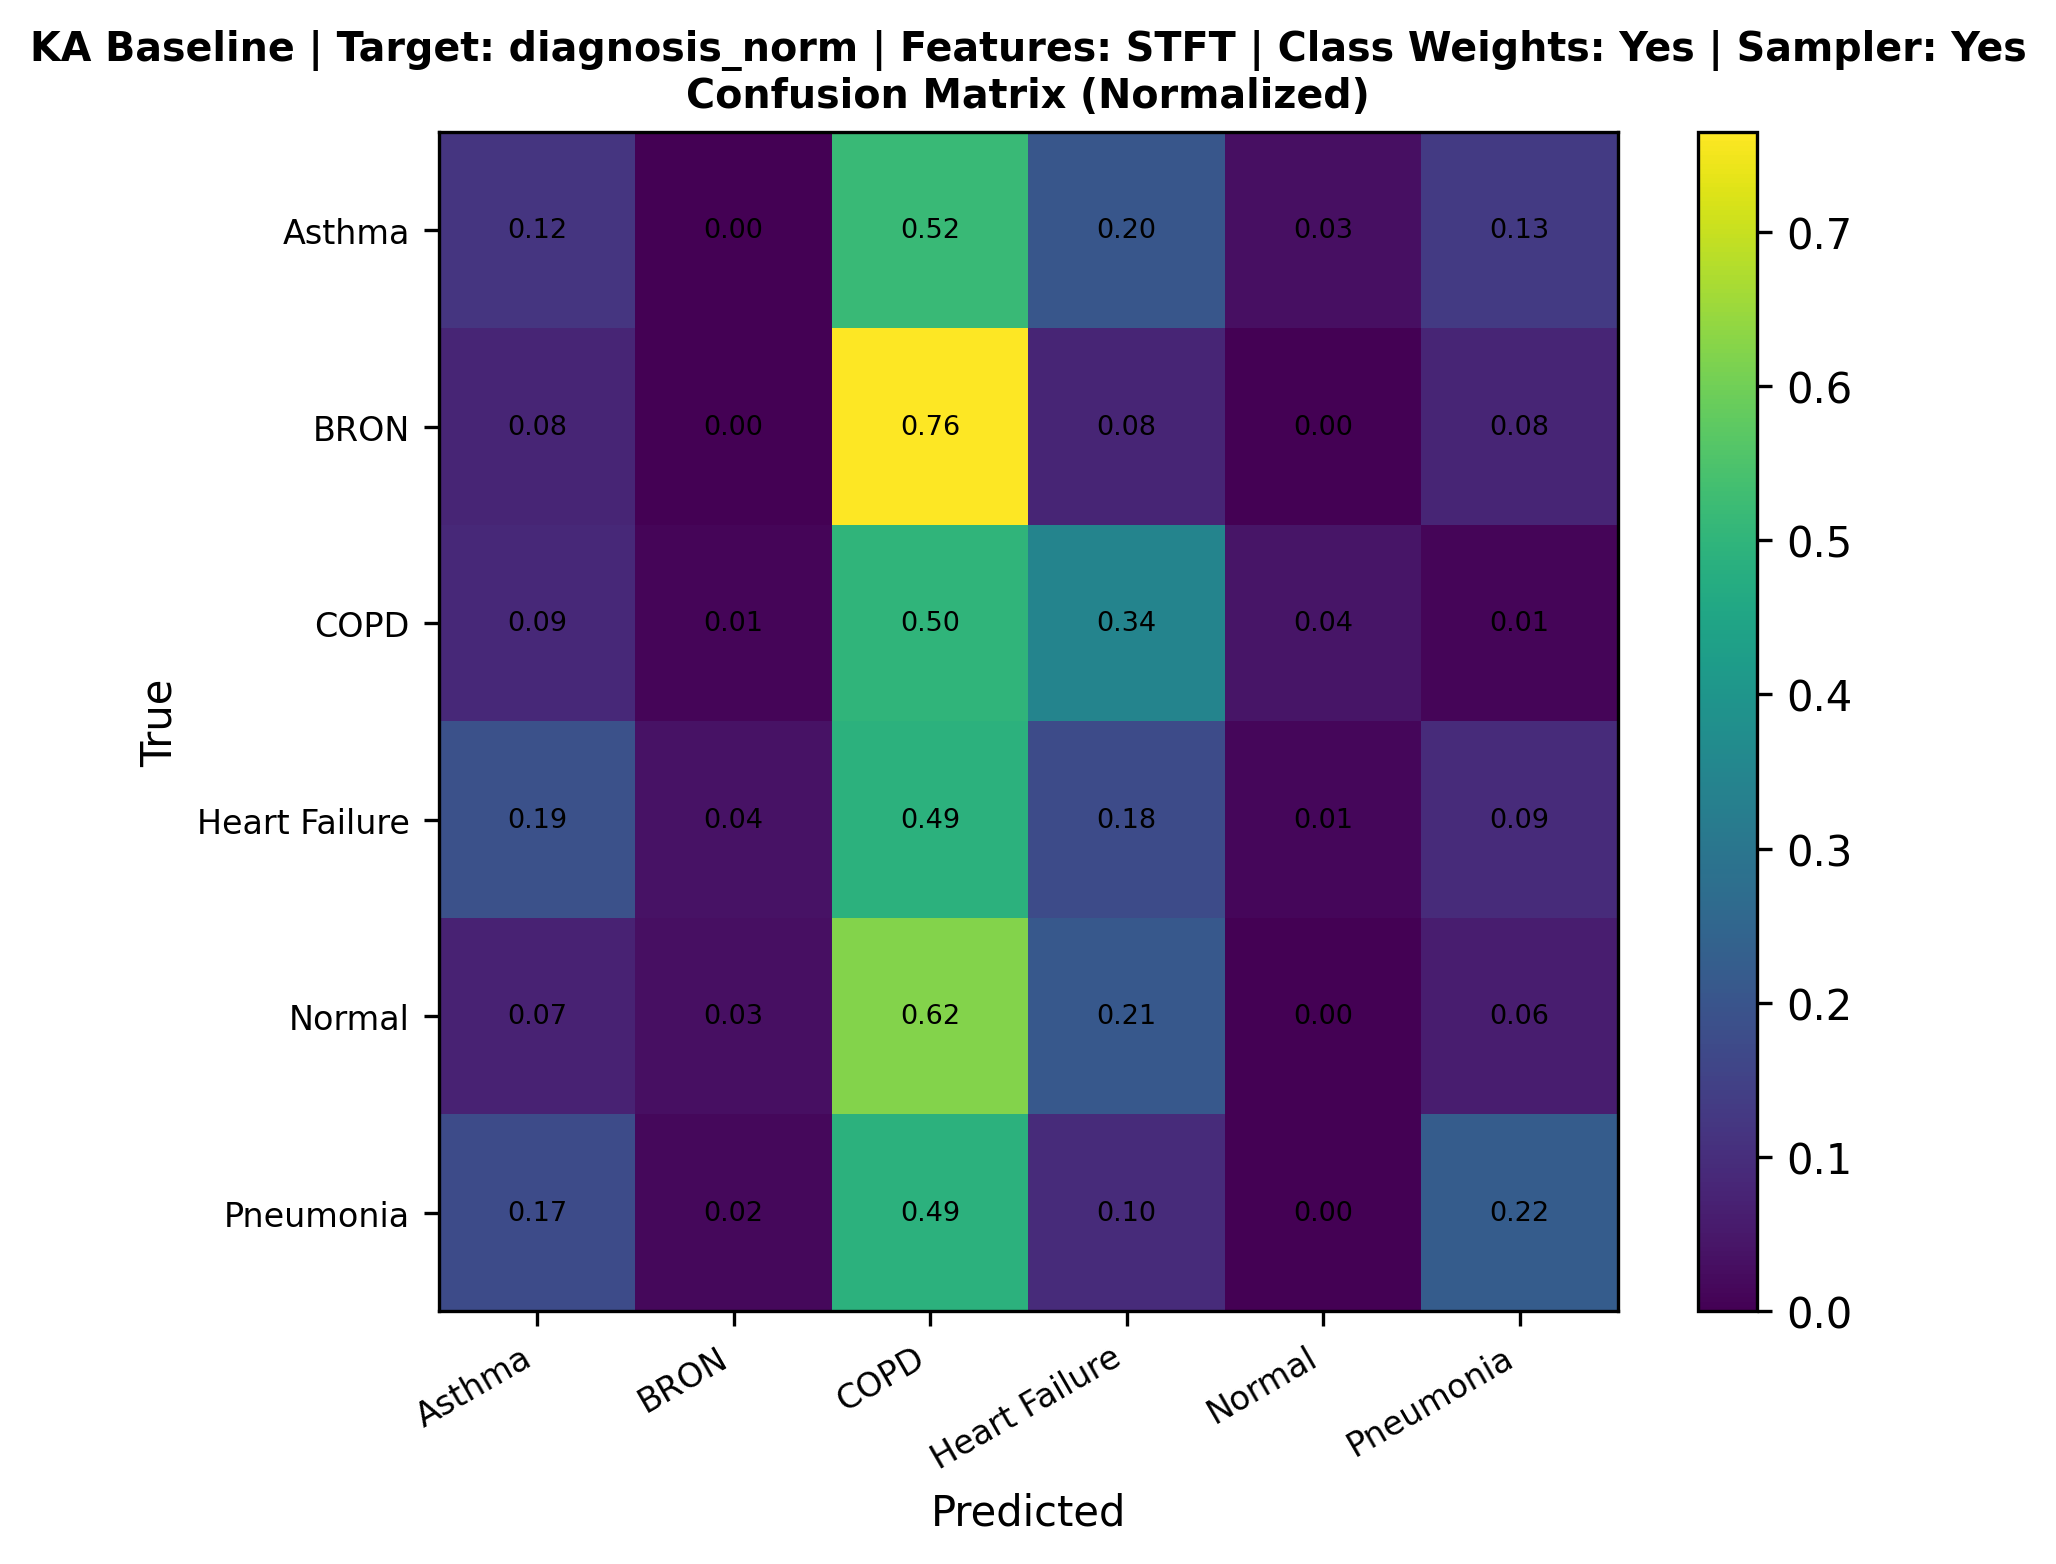

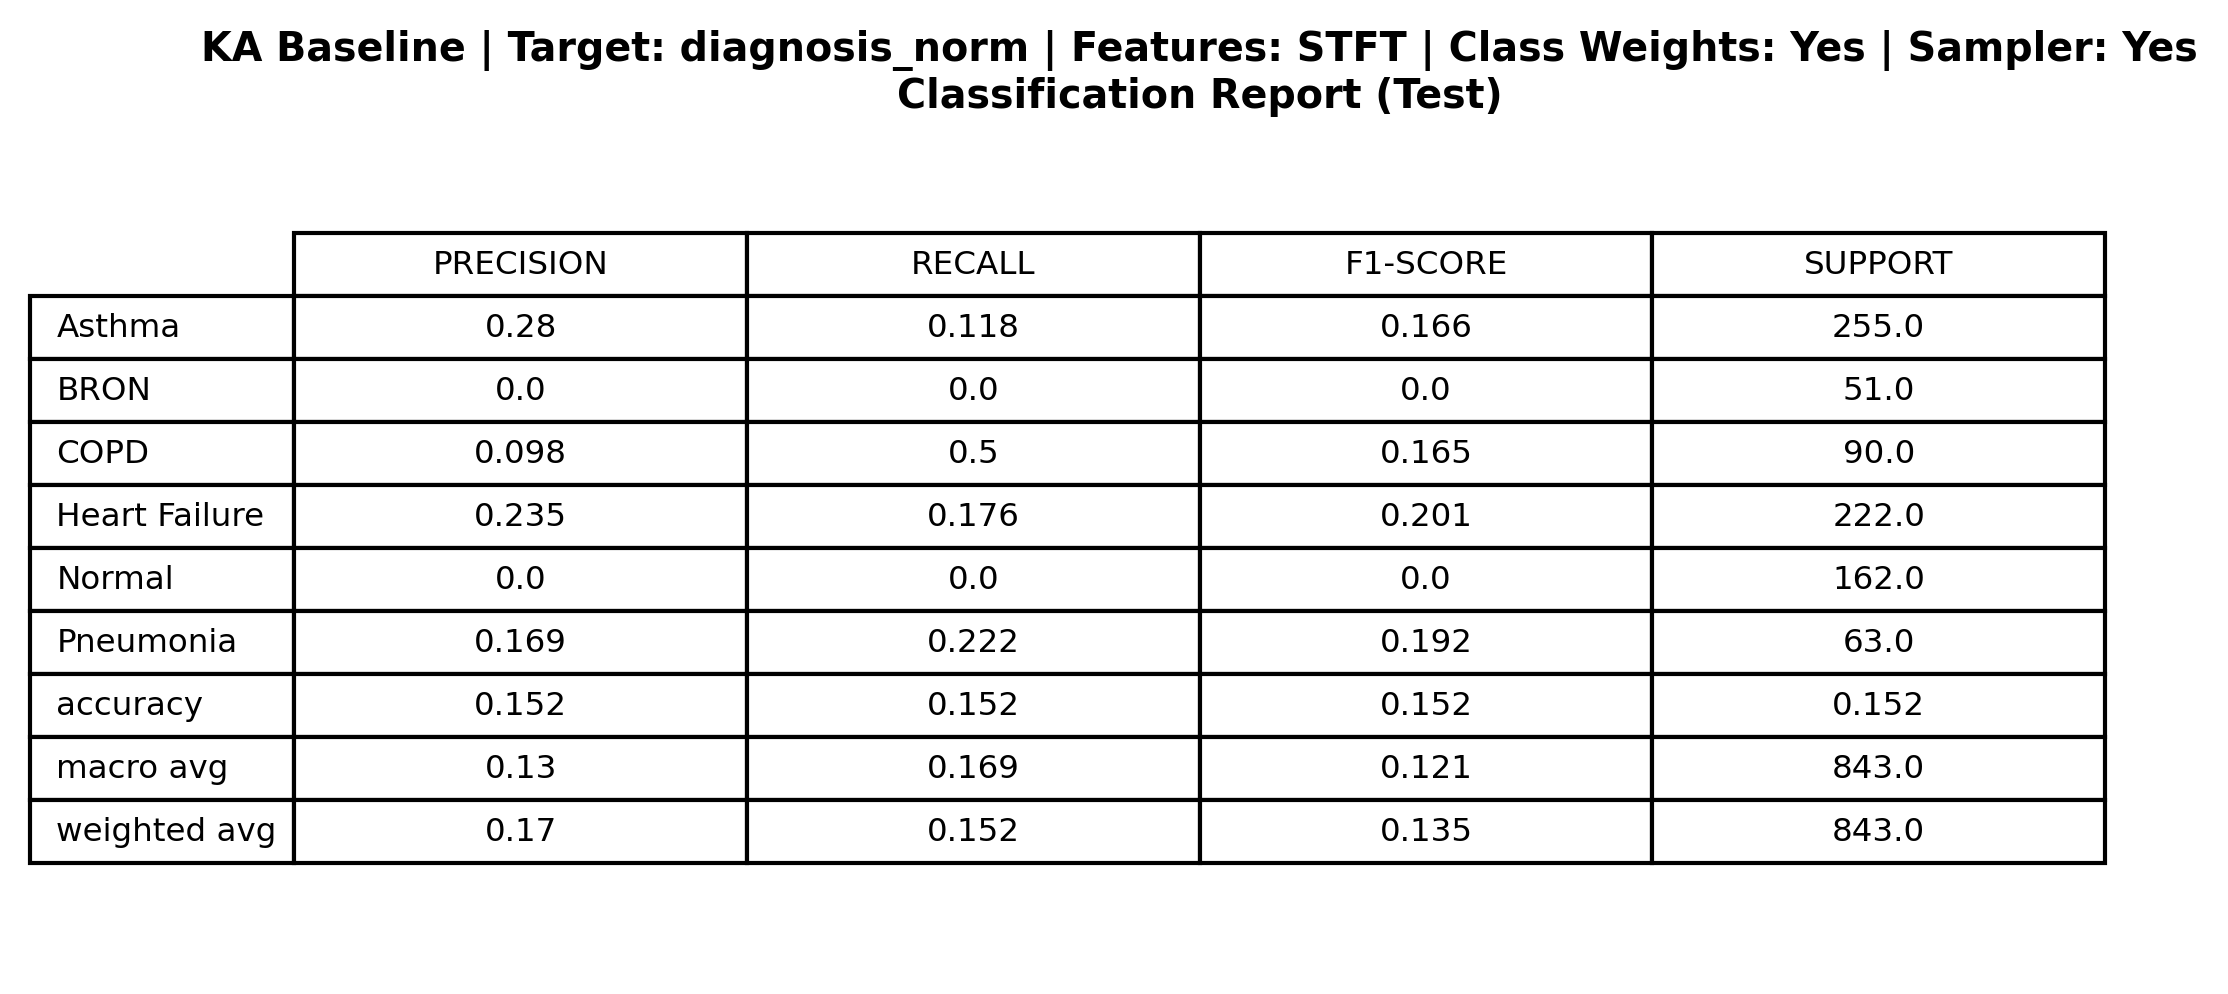

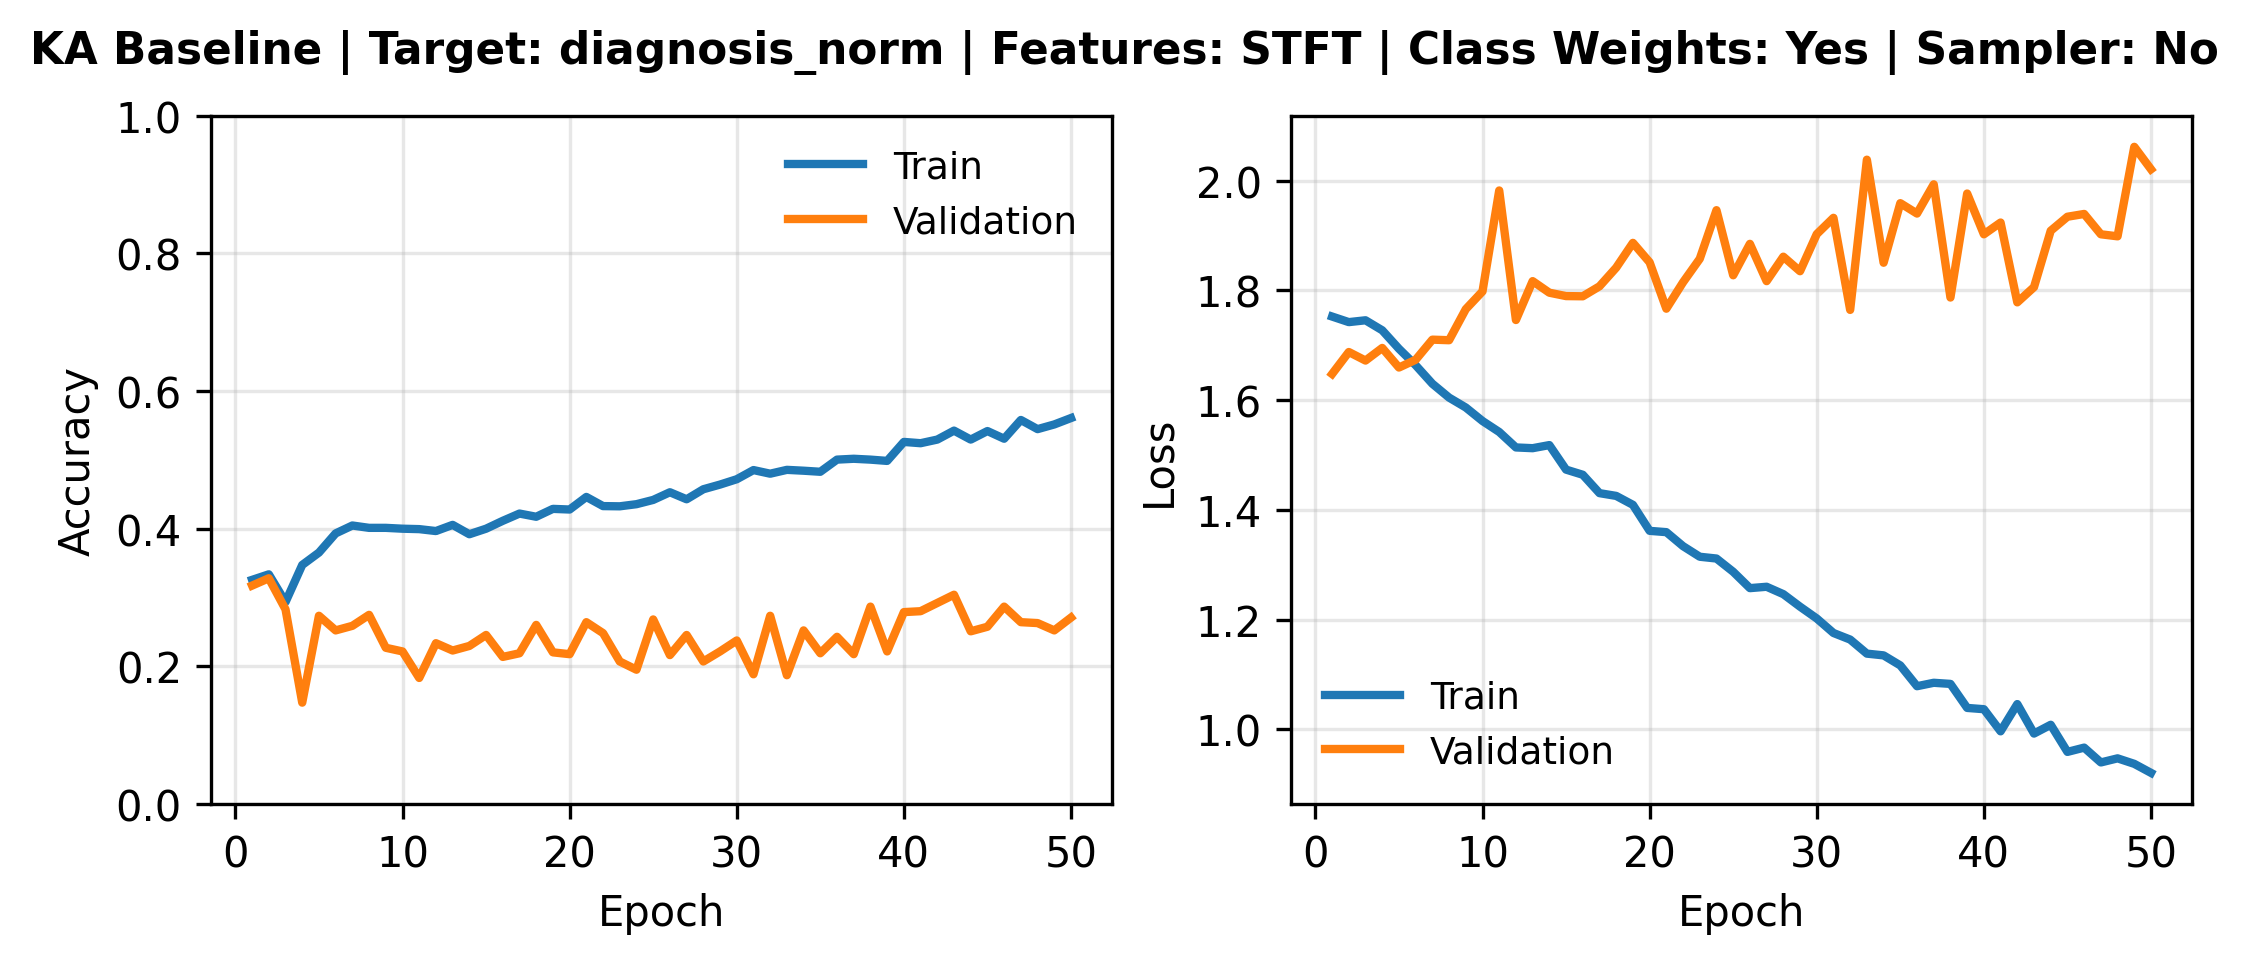

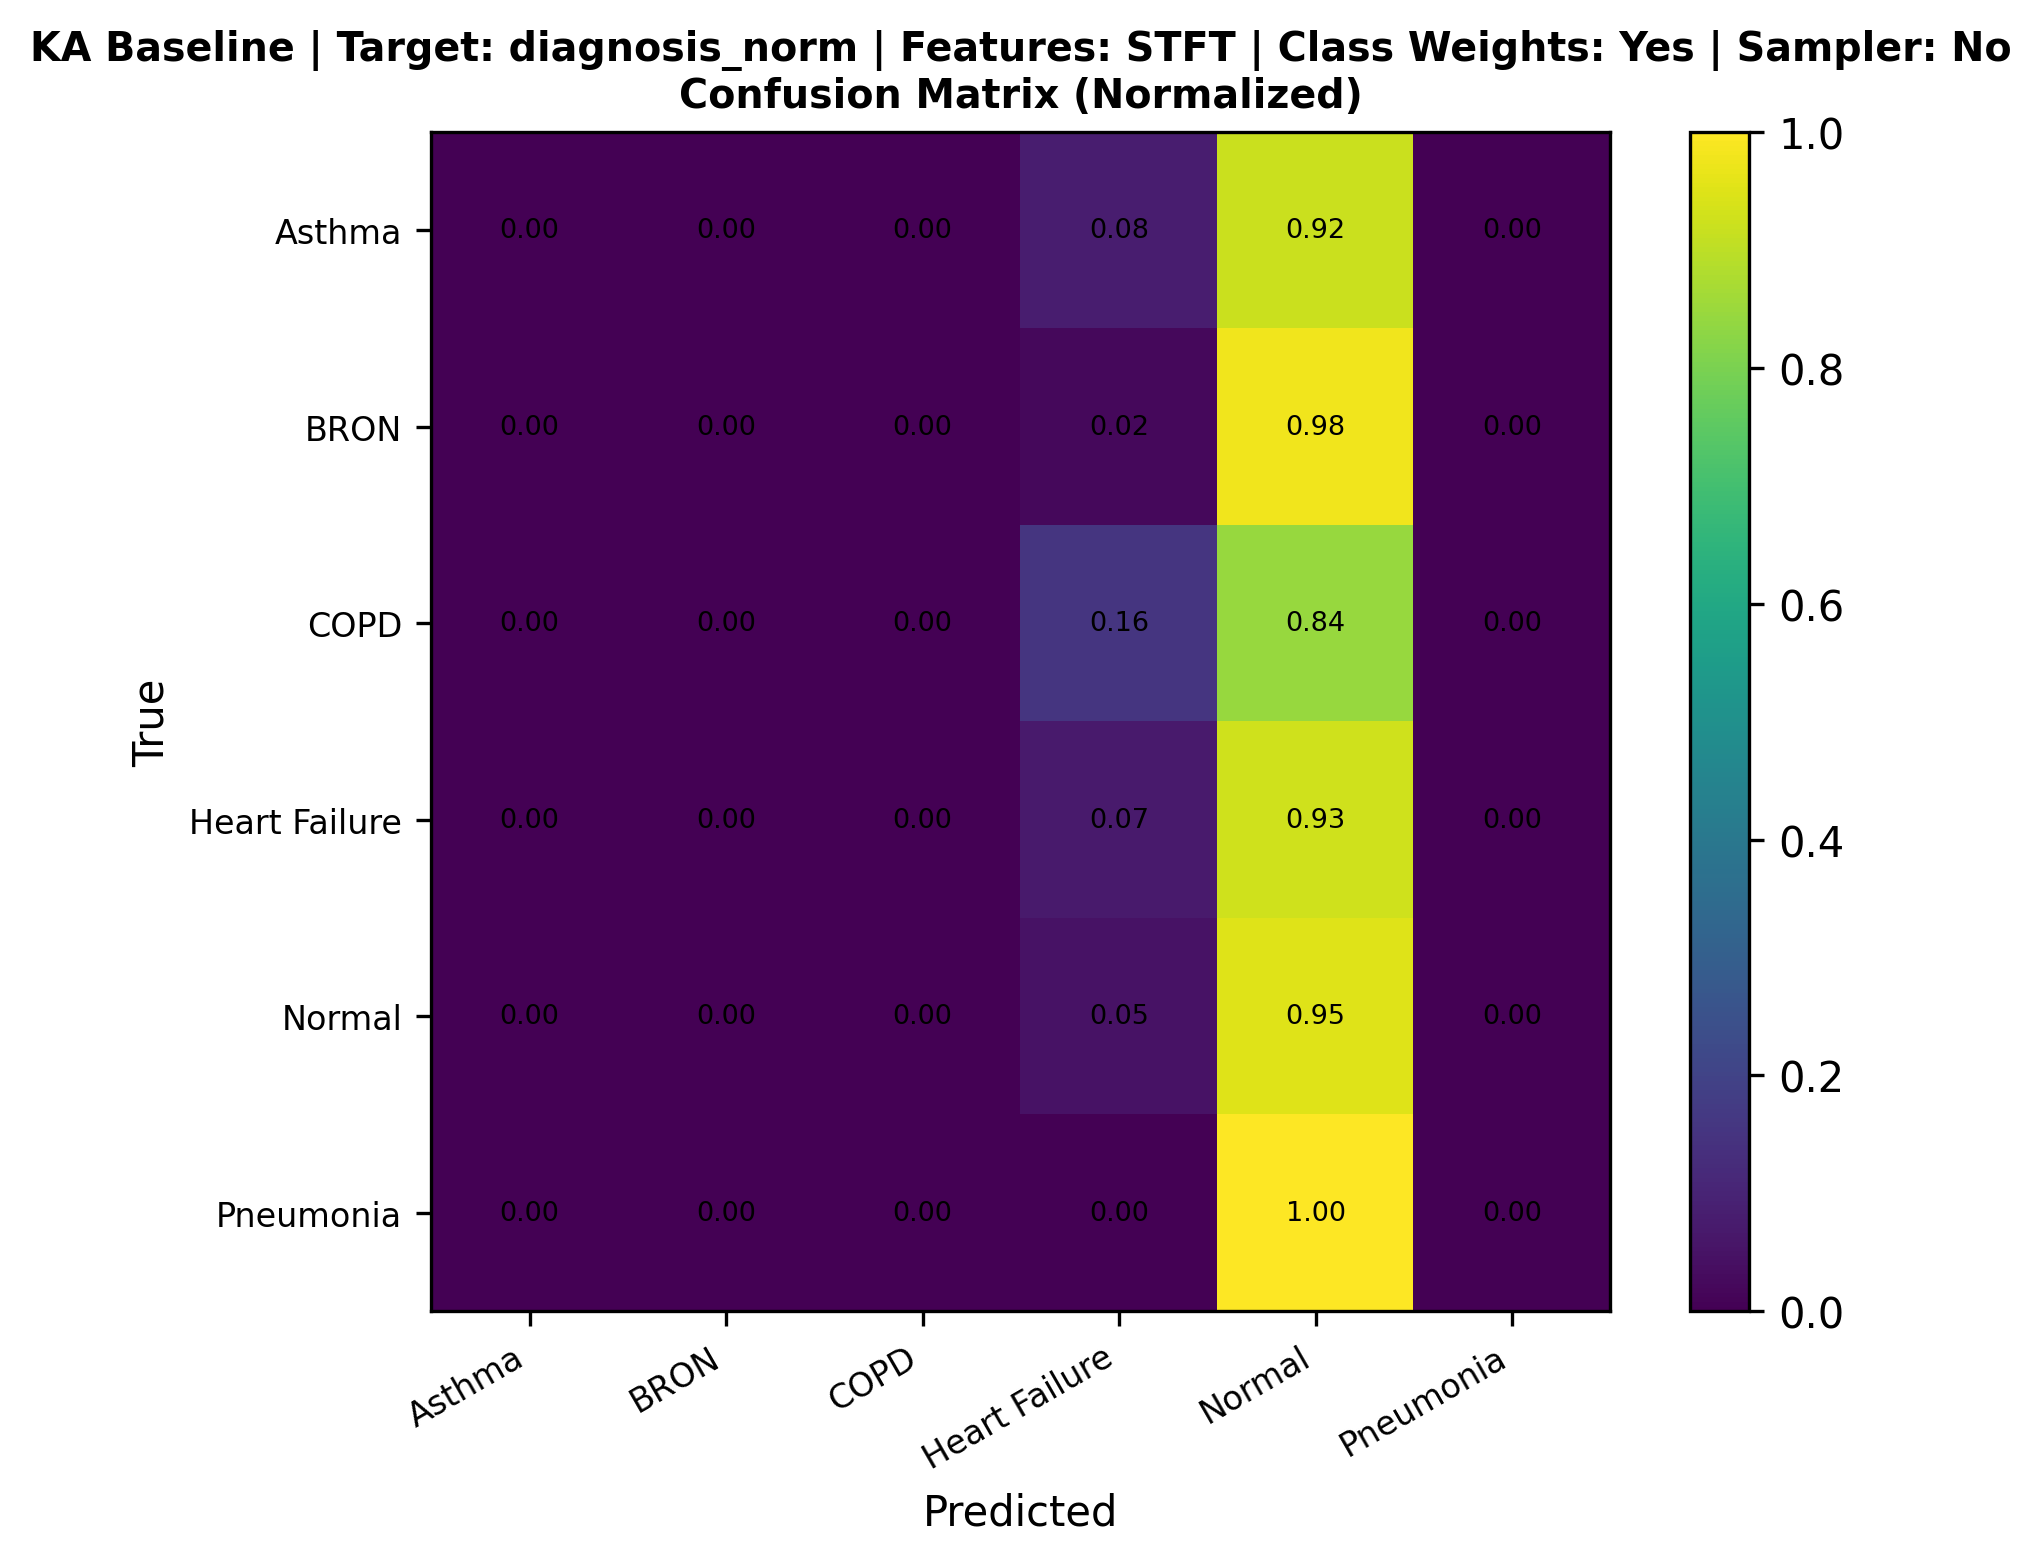

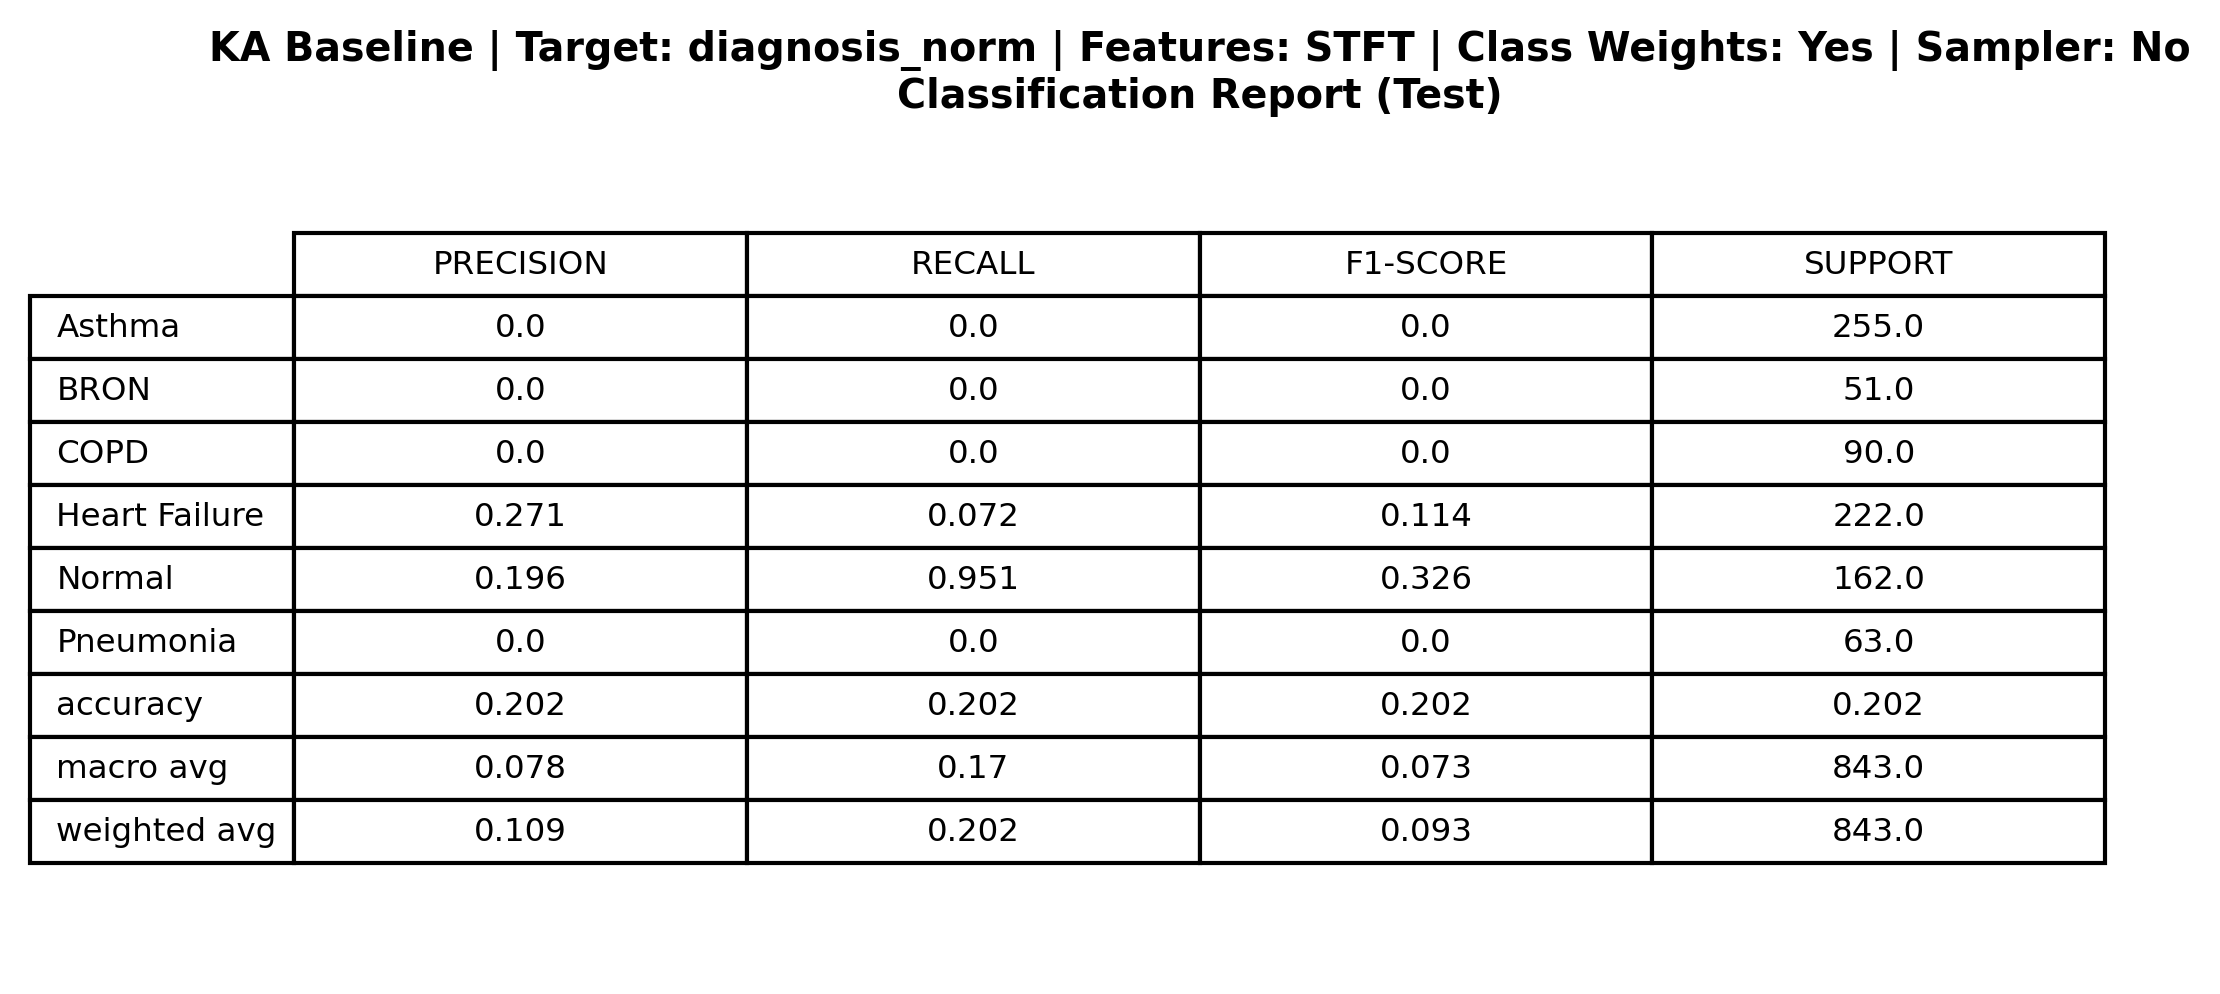

In [17]:
for run_name in summary_df["run"].tolist():
    d = OUT_DIR / run_name
    plot_curves(d)
    plot_cm(d, normalize="true")
    plot_report(d)
